## PROBLEM 

TO be able to predict car prices 

TO understand which features affect the car prices 

### LOADING DATA

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import pickle
import plotly.express as px
import streamlit as st

In [4]:
pip install pandas openpyxl

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Load the Excel file
excel_file = 'all_cars_data.xlsx'  # Replace with your file path
df = pd.read_excel(excel_file)

# Save as CSV
csv_file = 'cars_data.csv'  # Replace with your desired CSV file name
df.to_csv(csv_file, index=False)

print(f"File saved as {csv_file}")

File saved as cars_data.csv


In [6]:
cars_data = pd.read_csv('cars_data.csv')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

cars_data.head()

,Make,Model,Year,Trim,MSRP,Invoice Price,Used/New Price,Body Size,Body Style,Cylinders,Engine Aspiration,Drivetrain,Transmission,Horsepower,Torque,Highway Fuel Economy
0,Acura,Integra,2025,Base,"$32,400",NaN,"$32,400",Midsize,Hatchback,I4,Turbocharged,FWD,automatic,200 hp @ 6000 rpm,192 ft-lbs. @ 1800 rpm,37 mpg
1,Acura,Integra,2025,Base w/A-Spec Package,"$34,400",NaN,"$34,400",Midsize,Hatchback,I4,Turbocharged,FWD,automatic,200 hp @ 6000 rpm,192 ft-lbs. @ 1800 rpm,36 mpg
2,Acura,Integra,2025,Base w/A-Spec and Technology Packages,"$37,400",NaN,"$37,400",Midsize,Hatchback,I4,Turbocharged,FWD,manual,200 hp @ 6000 rpm,192 ft-lbs. @ 1800 rpm,36 mpg
3,Acura,Integra,2025,Base w/A-Spec and Technology Packages,"$37,400",NaN,"$37,400",Midsize,Hatchback,I4,Turbocharged,FWD,automatic,200 hp @ 6000 rpm,192 ft-lbs. @ 1800 rpm,36 mpg
4,Acura,MDX,2025,Base,"$50,900",NaN,"$50,900",Large,SUV,V6,Naturally Aspirated,FWD,automatic,290 hp @ 6200 rpm,267 ft-lbs. @ 4700 rpm,NaN


In [7]:
cars_data.shape

(29566, 16)

### UNDERSTANDING DATA

In [8]:
for column in cars_data:
    unique_vals = np.unique(cars_data[column].fillna('0'))
    nr_values = len(unique_vals)
    if nr_values <= 12:
        print("The number of values for feature {} :{} -- {}".format(column, nr_values, unique_vals))
    else:
        print("The number of values for feature {} :{}".format(column, nr_values))

The number of values for feature Make :51
The number of values for feature Model :747
The number of values for feature Year :11 -- [2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025]
The number of values for feature Trim :2909
The number of values for feature MSRP :9495
The number of values for feature Invoice Price :18127
The number of values for feature Used/New Price :20348
The number of values for feature Body Size :3 -- ['Compact' 'Large' 'Midsize']
The number of values for feature Body Style :12 -- ['Cargo Minivan' 'Cargo Van' 'Convertible' 'Convertible SUV' 'Coupe'
 'Hatchback' 'Passenger Minivan' 'Passenger Van' 'Pickup Truck' 'SUV'
 'Sedan' 'Wagon']
The number of values for feature Cylinders :12 -- ['0' 'Flat-4' 'Flat-6' 'I3' 'I4' 'I5' 'I6' 'V10' 'V12' 'V6' 'V8' 'W12']
The number of values for feature Engine Aspiration :6 -- ['Electric Motor' 'Naturally Aspirated' 'Supercharged' 'Turbocharged'
 'Twin-Turbo' 'Twincharged']
The number of values for feature Drivetrain :4 -- 

In [9]:
#checking for null values 

cars_data.isnull().sum()

Make                       0
Model                      0
Year                       0
Trim                       0
MSRP                       0
Invoice Price           2401
Used/New Price             0
Body Size                  0
Body Style                 0
Cylinders                900
Engine Aspiration          0
Drivetrain                 0
Transmission               0
Horsepower               181
Torque                  1026
Highway Fuel Economy    2095
dtype: int64

In [10]:
cars_data.dtypes

Make                    object
Model                   object
Year                     int64
Trim                    object
MSRP                    object
Invoice Price           object
Used/New Price          object
Body Size               object
Body Style              object
Cylinders               object
Engine Aspiration       object
Drivetrain              object
Transmission            object
Horsepower              object
Torque                  object
Highway Fuel Economy    object
dtype: object

### HANDLING MISSING VALUES 

In [11]:
cars_data = cars_data.drop(['Invoice Price', 'Highway Fuel Economy'], axis=1, inplace=False)

In [12]:
cars_data.columns

Index(['Make', 'Model', 'Year', 'Trim', 'MSRP', 'Used/New Price', 'Body Size',
       'Body Style', 'Cylinders', 'Engine Aspiration', 'Drivetrain',
       'Transmission', 'Horsepower', 'Torque'],
      dtype='object')

In [13]:
# Identify rows where 'Horsepower' is NaN
null_hp = cars_data[cars_data['Horsepower'].isna()]

# Get unique values of 'Make' for rows with null 'Horsepower'
unique_makes_with_null_hp = null_hp['Make'].unique()

# Filter the null_hp DataFrame to include only these unique 'Make' values
filtered_null_hp = null_hp[null_hp['Make'].isin(unique_makes_with_null_hp)]

unique_makes_with_null_hp = null_hp['Make'].unique()
print(unique_makes_with_null_hp)

['Ford' 'Tesla' 'Jeep' 'Audi' 'Cadillac' 'Mitsubishi' 'Chevrolet'
 'Lincoln' 'Mercedes-Benz']


### filling hp with mean (brand-specific)

In [14]:
# Step 1: Convert the column to strings and extract numeric values
cars_data['Horsepower'] = cars_data['Horsepower'].astype(str).str.extract(r'(\d+)')

# Convert to float, coercing errors to NaN
cars_data['Horsepower'] = pd.to_numeric(cars_data['Horsepower'], errors='coerce')

# Step 2: Calculate the mean horsepower for each brand
brand_mean_horsepower = cars_data.groupby('Make')['Horsepower'].transform('mean')

# Step 3: Fill missing values with the brand-specific mean
cars_data['Horsepower'].fillna(brand_mean_horsepower, inplace=True)

# Verify the result
print(cars_data[['Make', 'Horsepower']].head())

    Make  Horsepower
0  Acura       200.0
1  Acura       200.0
2  Acura       200.0
3  Acura       200.0
4  Acura       290.0


C:\Users\tevfi\AppData\Local\Temp\ipykernel_22168\1392762870.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cars_data['Horsepower'].fillna(brand_mean_horsepower, inplace=True)


In [15]:
#checking for null values 

cars_data.isnull().sum()

Make                    0
Model                   0
Year                    0
Trim                    0
MSRP                    0
Used/New Price          0
Body Size               0
Body Style              0
Cylinders             900
Engine Aspiration       0
Drivetrain              0
Transmission            0
Horsepower              0
Torque               1026
dtype: int64

### Filling torque with mean (brand specific)

In [16]:
# Identify rows where 'Torque' is NaN
null_torque = cars_data[cars_data['Torque'].isna()]

# Get unique values of 'Make' for rows with null 'Horsepower'
unique_makes_with_null_torque = null_torque['Make'].unique()

# Filter the null_hp DataFrame to include only these unique 'Make' values
filtered_null_torque = null_torque[null_torque['Make'].isin(unique_makes_with_null_torque)]

unique_makes_with_null_torque = null_torque['Make'].unique()
print(unique_makes_with_null_torque)

['BMW' 'Ford' 'Honda' 'Lexus' 'Lincoln' 'Mazda' 'Toyota' 'Audi' 'Chrysler'
 'Hyundai' 'Tesla' 'Volkswagen' 'Cadillac' 'Jeep' 'Lucid' 'Subaru'
 'Mitsubishi' 'Land Rover' 'INFINITI' 'Chevrolet' 'Mercedes-Benz']


In [17]:
# Step 1: Convert the column to strings and extract numeric values
cars_data['Torque'] = cars_data['Torque'].astype(str).str.extract(r'(\d+)')

# Convert to float, coercing errors to NaN
cars_data['Torque'] = pd.to_numeric(cars_data['Torque'], errors='coerce')

# Step 2: Calculate the mean Torque for each brand
brand_mean_torque = cars_data.groupby('Make')['Torque'].transform('mean')

# Step 3: Fill missing values with the brand-specific mean
cars_data['Torque'].fillna(brand_mean_torque, inplace=True)

# Verify the result
print(cars_data[['Make', 'Torque']].head())

    Make  Torque
0  Acura   192.0
1  Acura   192.0
2  Acura   192.0
3  Acura   192.0
4  Acura   267.0


C:\Users\tevfi\AppData\Local\Temp\ipykernel_22168\1406237764.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cars_data['Torque'].fillna(brand_mean_torque, inplace=True)


In [18]:
cars_data.isnull().sum()

Make                   0
Model                  0
Year                   0
Trim                   0
MSRP                   0
Used/New Price         0
Body Size              0
Body Style             0
Cylinders            900
Engine Aspiration      0
Drivetrain             0
Transmission           0
Horsepower             0
Torque                 0
dtype: int64

### Handling MSRP AND USED/NEW PRICE VALUES AS FLOAT AND REMOVING DOLLARS SIGN

In [19]:
cars_data['MSRP'] = cars_data['MSRP'].str.replace('$', '')
cars_data['MSRP'] = cars_data['MSRP'].str.replace(',', '').astype(float)

In [20]:
cars_data['Used/New Price'] = cars_data['Used/New Price'].str.replace('$', '')
cars_data['Used/New Price'] = cars_data['Used/New Price'].str.replace(',', '').astype(float)

In [21]:
cars_data.dtypes

Make                  object
Model                 object
Year                   int64
Trim                  object
MSRP                 float64
Used/New Price       float64
Body Size             object
Body Style            object
Cylinders             object
Engine Aspiration     object
Drivetrain            object
Transmission          object
Horsepower           float64
Torque               float64
dtype: object

In [22]:
cars_data.head()

,Make,Model,Year,Trim,MSRP,Used/New Price,Body Size,Body Style,Cylinders,Engine Aspiration,Drivetrain,Transmission,Horsepower,Torque
0,Acura,Integra,2025,Base,32400.0,32400.0,Midsize,Hatchback,I4,Turbocharged,FWD,automatic,200.0,192.0
1,Acura,Integra,2025,Base w/A-Spec Package,34400.0,34400.0,Midsize,Hatchback,I4,Turbocharged,FWD,automatic,200.0,192.0
2,Acura,Integra,2025,Base w/A-Spec and Technology Packages,37400.0,37400.0,Midsize,Hatchback,I4,Turbocharged,FWD,manual,200.0,192.0
3,Acura,Integra,2025,Base w/A-Spec and Technology Packages,37400.0,37400.0,Midsize,Hatchback,I4,Turbocharged,FWD,automatic,200.0,192.0
4,Acura,MDX,2025,Base,50900.0,50900.0,Large,SUV,V6,Naturally Aspirated,FWD,automatic,290.0,267.0


### HANDLING NULL VALUES AND ONE HOT ENCODING CYLINDERS COLUMN

In [23]:
cars_data['Cylinders'].fillna('Unknown', inplace=True)

C:\Users\tevfi\AppData\Local\Temp\ipykernel_22168\212839767.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cars_data['Cylinders'].fillna('Unknown', inplace=True)


In [24]:
# Perform one-hot encoding
cylinders_encoded = pd.get_dummies(cars_data['Cylinders'], prefix='Cylinders')
# One-hot encoding sonucunda oluşan sütunları sayısal forma dönüştürme
#cylinders_encoded = cylinders_encoded.astype(int)

# Concatenate the encoded columns with the original DataFrame
cars_data = pd.concat([cars_data, cylinders_encoded], axis=1)

# Drop the original Cylinders column
cars_data.drop('Cylinders', axis=1, inplace=True)

In [25]:
cars_data.head()

,Make,Model,Year,Trim,MSRP,Used/New Price,Body Size,Body Style,Engine Aspiration,Drivetrain,Transmission,Horsepower,Torque,Cylinders_Flat-4,Cylinders_Flat-6,Cylinders_I3,Cylinders_I4,Cylinders_I5,Cylinders_I6,Cylinders_Unknown,Cylinders_V10,Cylinders_V12,Cylinders_V6,Cylinders_V8,Cylinders_W12
0,Acura,Integra,2025,Base,32400.0,32400.0,Midsize,Hatchback,Turbocharged,FWD,automatic,200.0,192.0,False,False,False,True,False,False,False,False,False,False,False,False
1,Acura,Integra,2025,Base w/A-Spec Package,34400.0,34400.0,Midsize,Hatchback,Turbocharged,FWD,automatic,200.0,192.0,False,False,False,True,False,False,False,False,False,False,False,False
2,Acura,Integra,2025,Base w/A-Spec and Technology Packages,37400.0,37400.0,Midsize,Hatchback,Turbocharged,FWD,manual,200.0,192.0,False,False,False,True,False,False,False,False,False,False,False,False
3,Acura,Integra,2025,Base w/A-Spec and Technology Packages,37400.0,37400.0,Midsize,Hatchback,Turbocharged,FWD,automatic,200.0,192.0,False,False,False,True,False,False,False,False,False,False,False,False
4,Acura,MDX,2025,Base,50900.0,50900.0,Large,SUV,Naturally Aspirated,FWD,automatic,290.0,267.0,False,False,False,False,False,False,False,False,False,True,False,False


In [26]:
cars_data.isnull().sum()

Make                 0
Model                0
Year                 0
Trim                 0
MSRP                 0
Used/New Price       0
Body Size            0
Body Style           0
Engine Aspiration    0
Drivetrain           0
Transmission         0
Horsepower           0
Torque               0
Cylinders_Flat-4     0
Cylinders_Flat-6     0
Cylinders_I3         0
Cylinders_I4         0
Cylinders_I5         0
Cylinders_I6         0
Cylinders_Unknown    0
Cylinders_V10        0
Cylinders_V12        0
Cylinders_V6         0
Cylinders_V8         0
Cylinders_W12        0
dtype: int64

In [27]:
cars_data.dtypes

Make                  object
Model                 object
Year                   int64
Trim                  object
MSRP                 float64
Used/New Price       float64
Body Size             object
Body Style            object
Engine Aspiration     object
Drivetrain            object
Transmission          object
Horsepower           float64
Torque               float64
Cylinders_Flat-4        bool
Cylinders_Flat-6        bool
Cylinders_I3            bool
Cylinders_I4            bool
Cylinders_I5            bool
Cylinders_I6            bool
Cylinders_Unknown       bool
Cylinders_V10           bool
Cylinders_V12           bool
Cylinders_V6            bool
Cylinders_V8            bool
Cylinders_W12           bool
dtype: object

In [28]:
cars_data.shape

(29566, 25)

### DATA EXPLORETAION / VIZ

In [29]:
#g = sns.pairplot(cars_data)

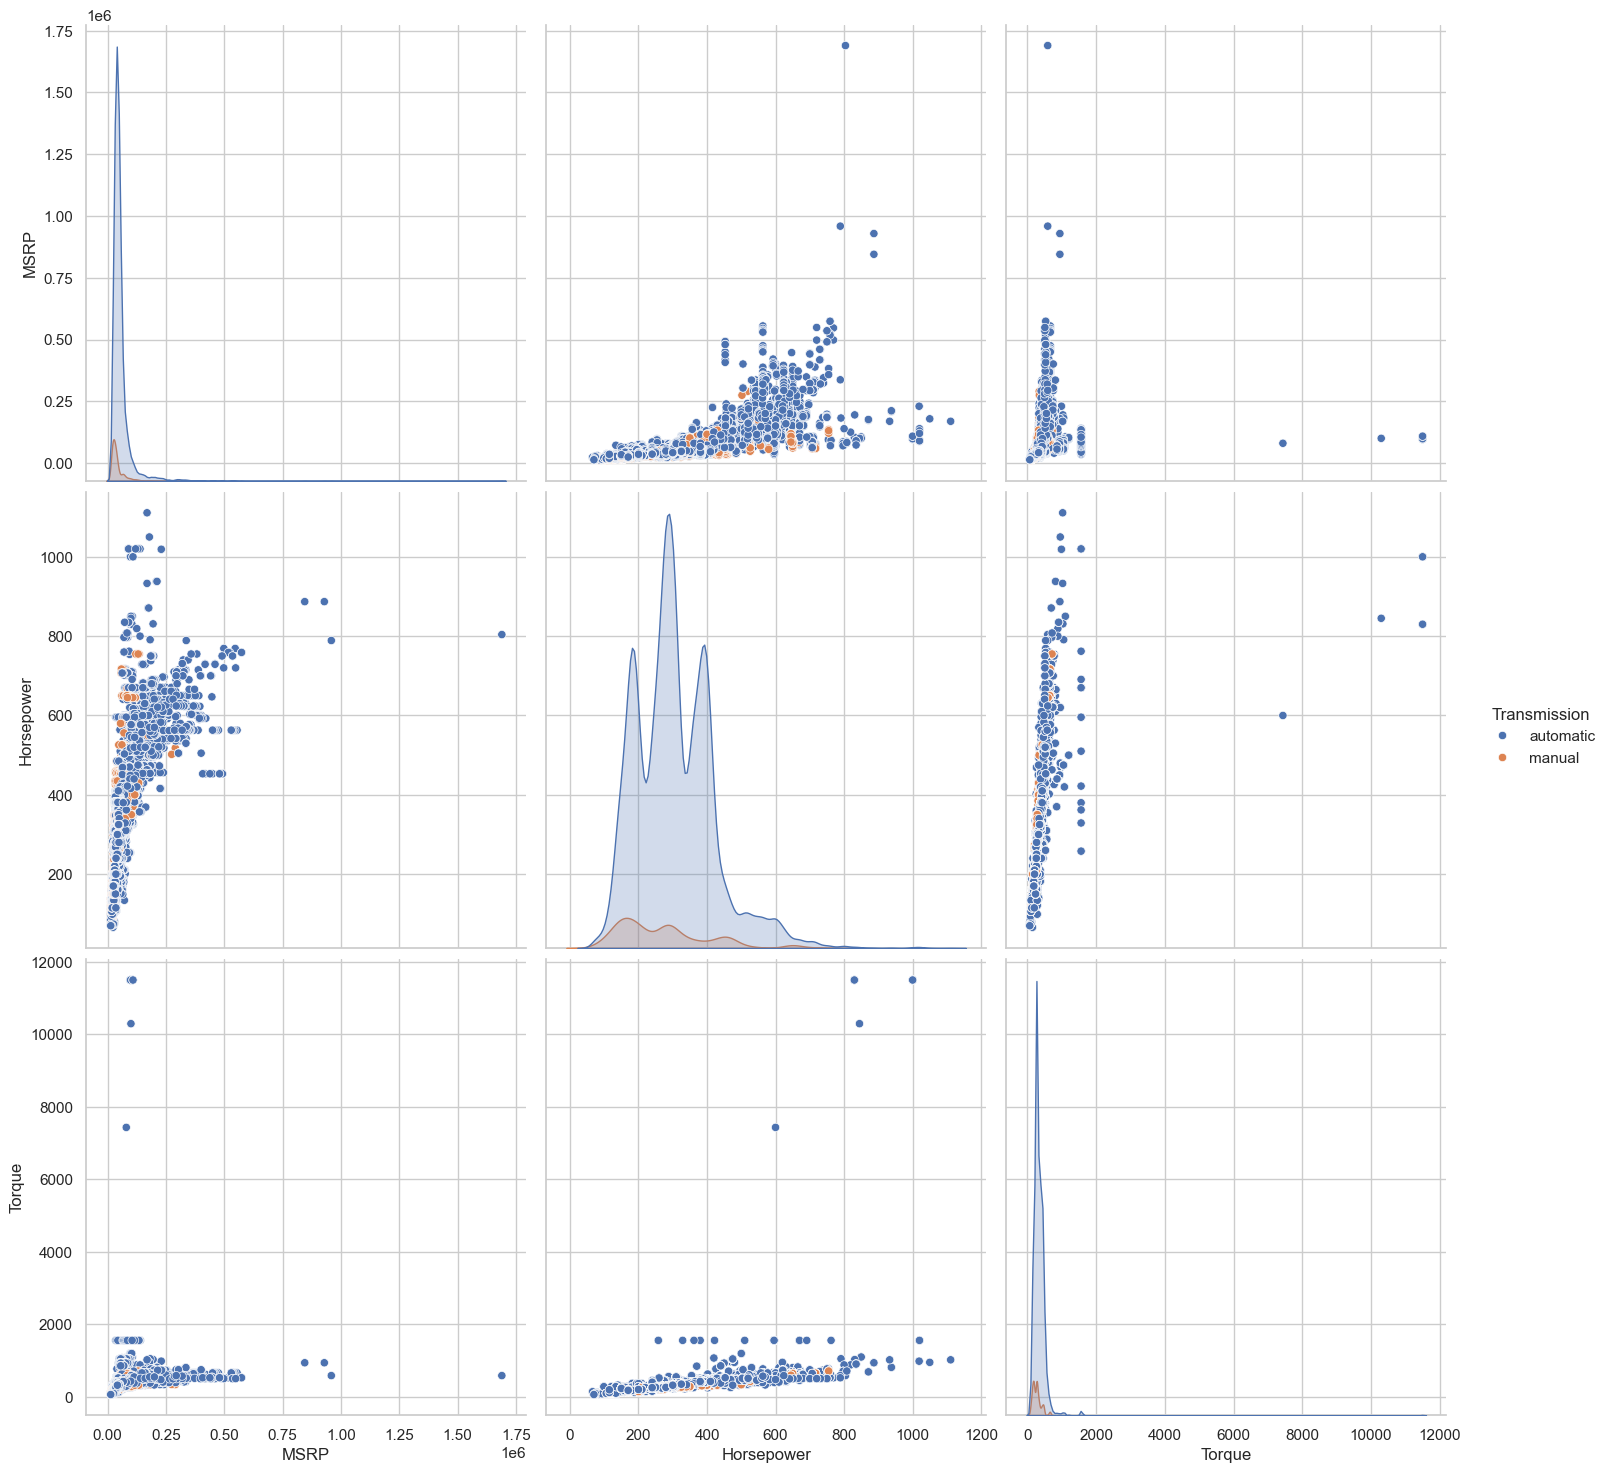

In [92]:
g = sns.pairplot(cars_data[['MSRP', 'Horsepower', 'Torque', 'Transmission']], hue = 'Transmission', height = 5)

 The distribution of MSRP for each category in the categorical column:

In [ ]:
# Viz cat columns

# Set the style for plots
sns.set(style="whitegrid")

# List of categorical columns
categorical_columns = ['Make', 'Body Size', 'Body Style', 'Engine Aspiration', 'Drivetrain', 'Transmission']

# Loop through each categorical column and create a plot
for column in categorical_columns:
    plt.figure(figsize=(10, 6))  # Set the figure size
    
    # Create a bar plot
    sns.barplot(x=column, y='MSRP', data=cars_data)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90)
    
    # Add title and labels
    plt.title(f'{column} vs MSRP')
    plt.xlabel(column)
    plt.ylabel('MSRP')
    
    # Show the plot
    plt.show()

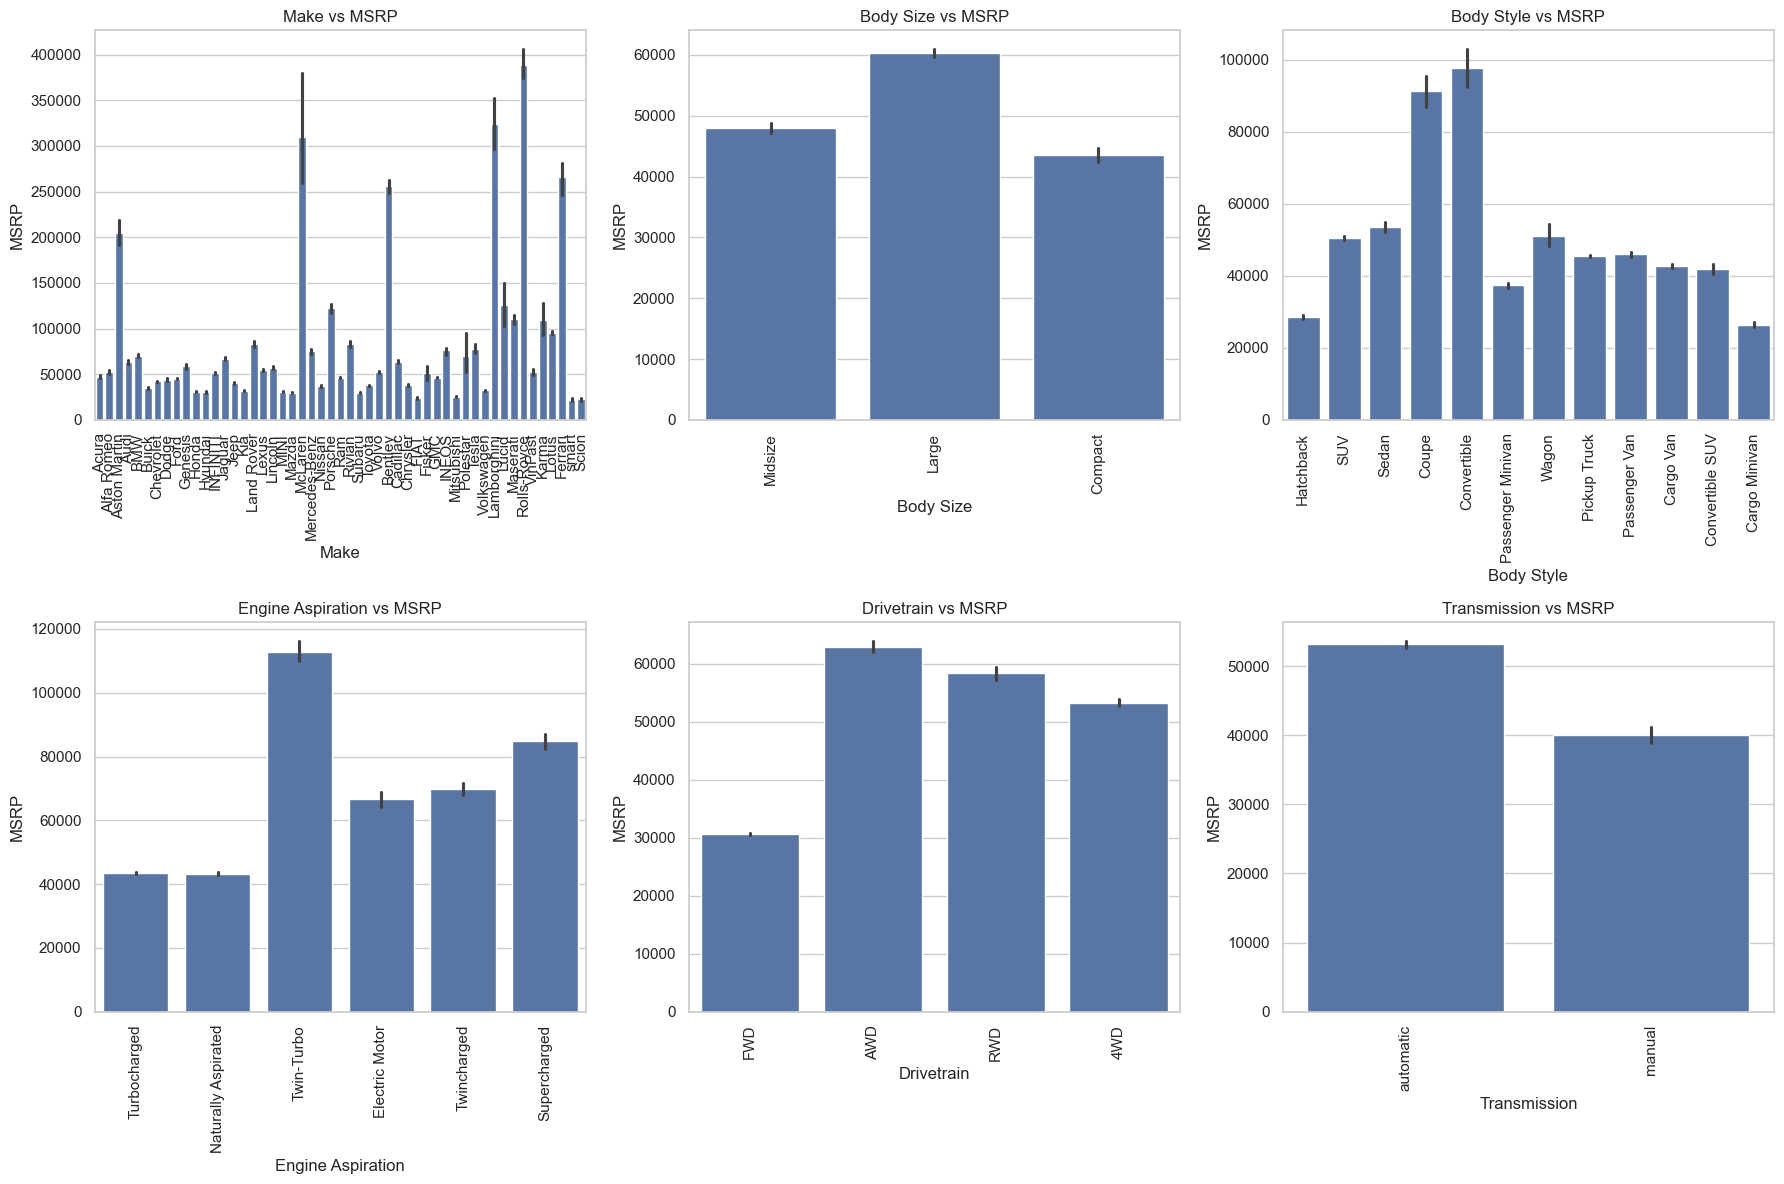

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for plots
sns.set(style="whitegrid")

# List of categorical columns
categorical_columns = ['Make', 'Body Size', 'Body Style', 'Engine Aspiration', 'Drivetrain', 'Transmission']

# Define the number of subplots (2 rows, 3 columns for better visualization)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

# Flatten the axes array to easily iterate through
axes = axes.flatten()

# Loop through each categorical column and create a plot in the corresponding subplot
for i, column in enumerate(categorical_columns):
    sns.barplot(x=column, y='MSRP', data=cars_data, ax=axes[i])
    axes[i].set_title(f'{column} vs MSRP')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('MSRP')
    axes[i].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better readability

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


 Bar Plot (Mean MSRP per Category):

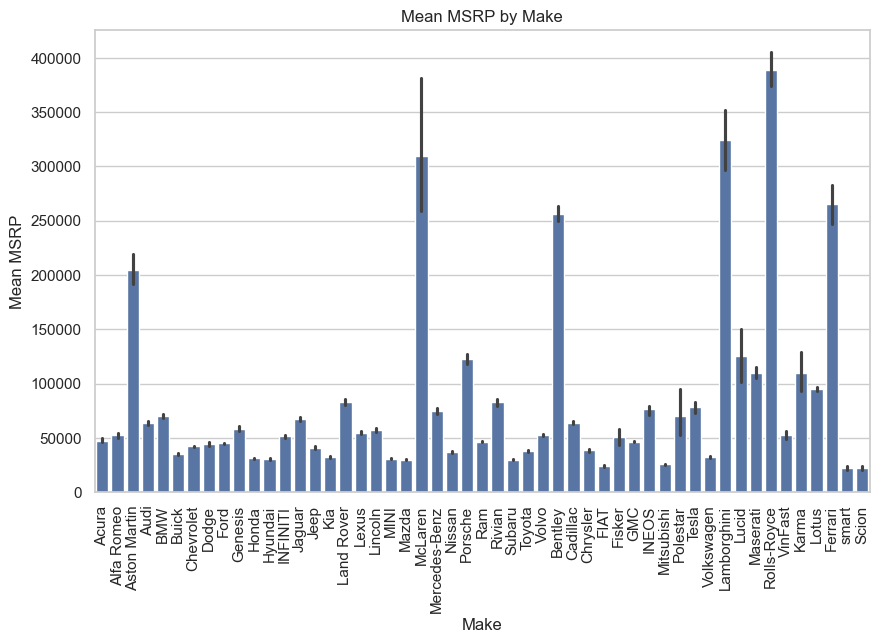

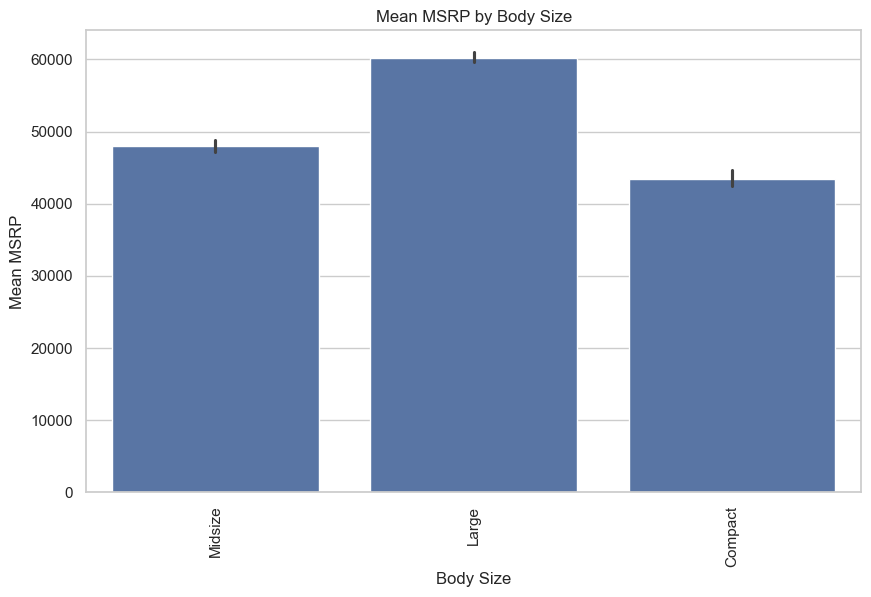

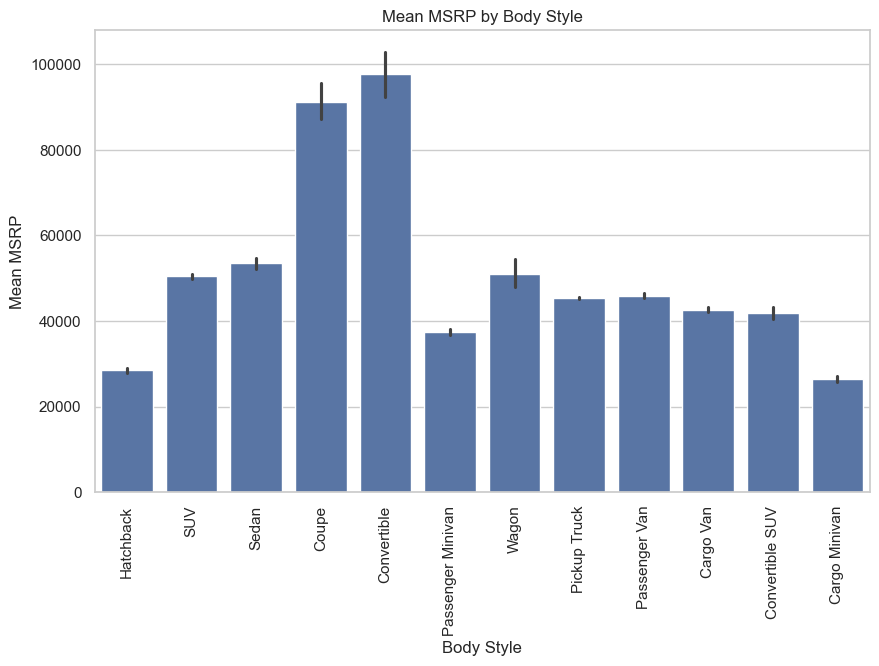

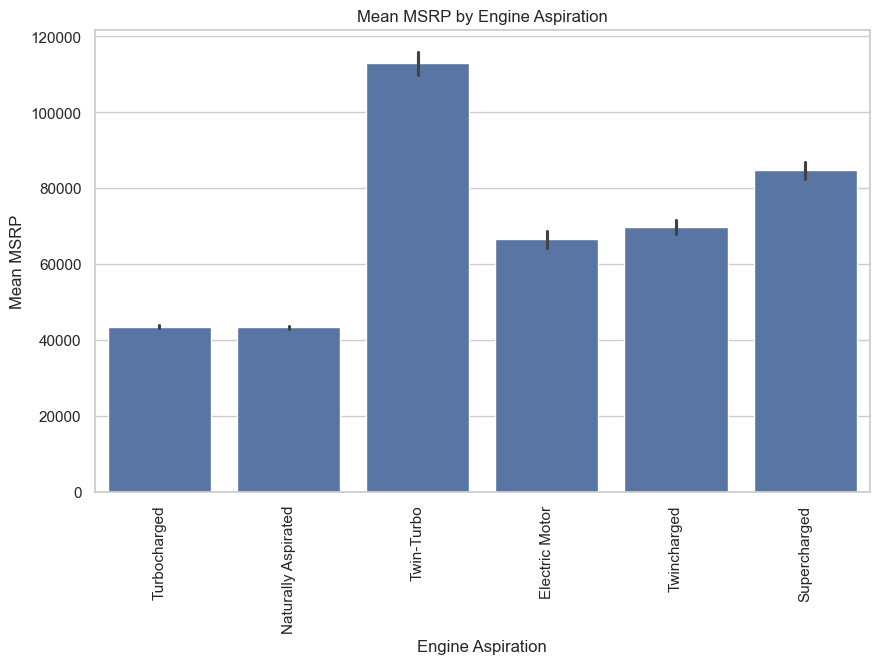

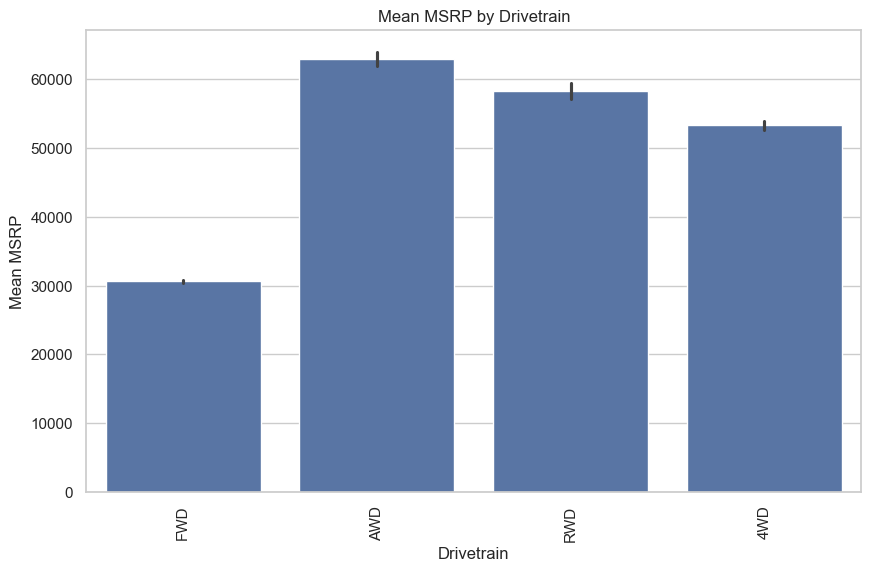

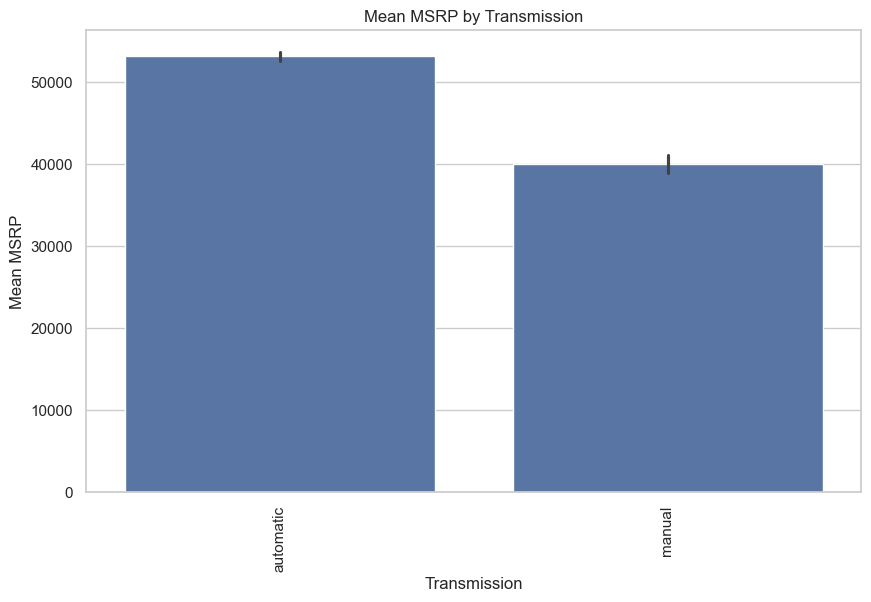

In [32]:
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    
    # Create a bar plot
    sns.barplot(x=column, y='MSRP', data=cars_data, estimator='mean')
    
    plt.xticks(rotation=90)
    plt.title(f'Mean MSRP by {column}')
    plt.xlabel(column)
    plt.ylabel('Mean MSRP')
    plt.show()

Violin Plot: the distribution of MSRP more clearly

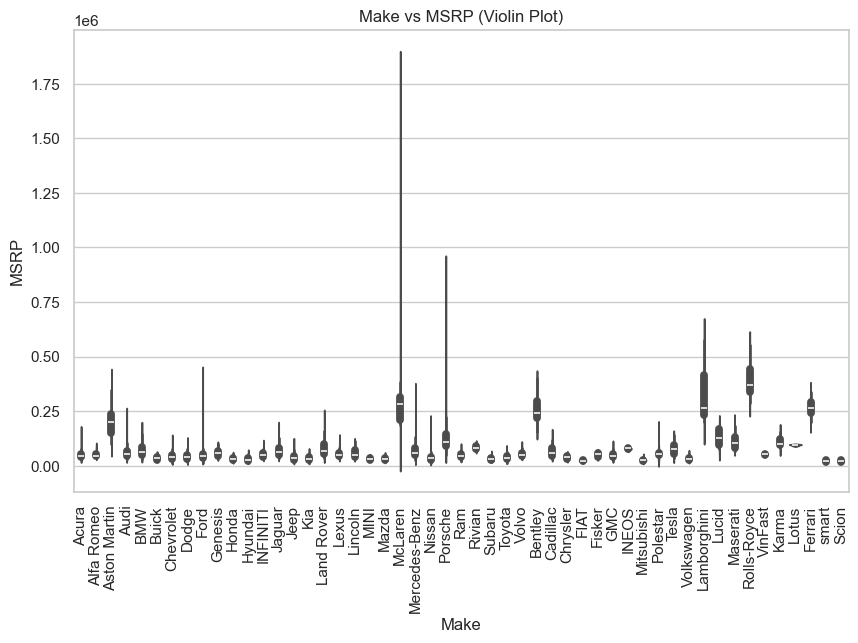

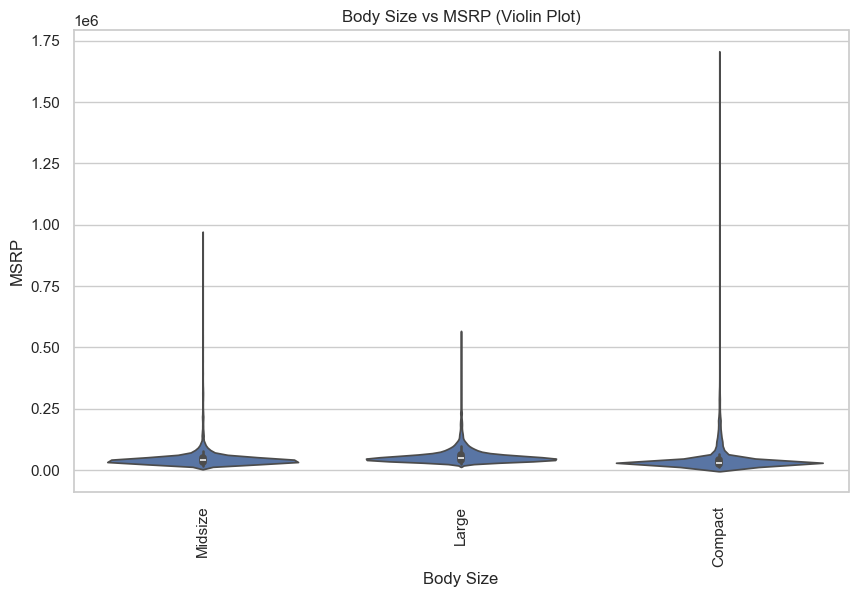

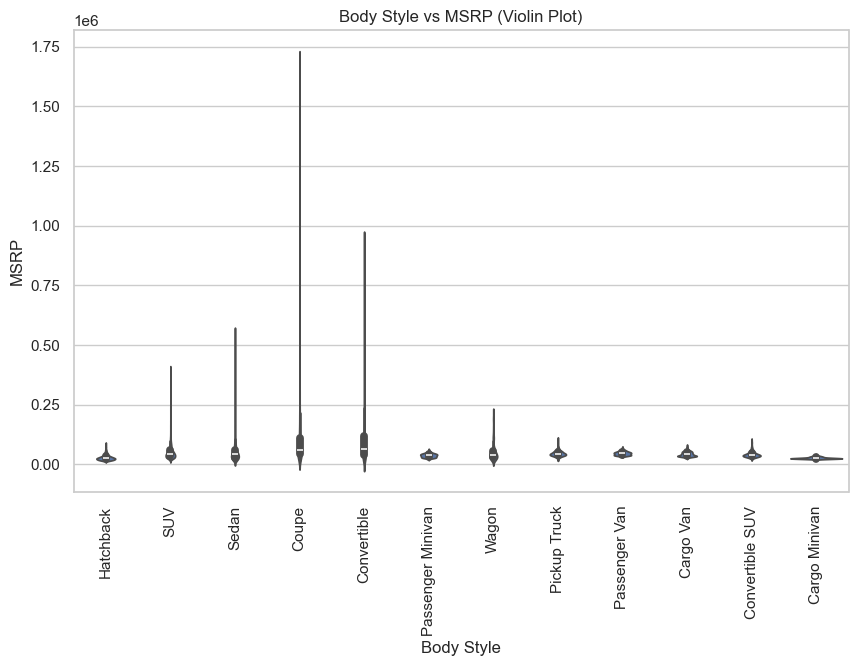

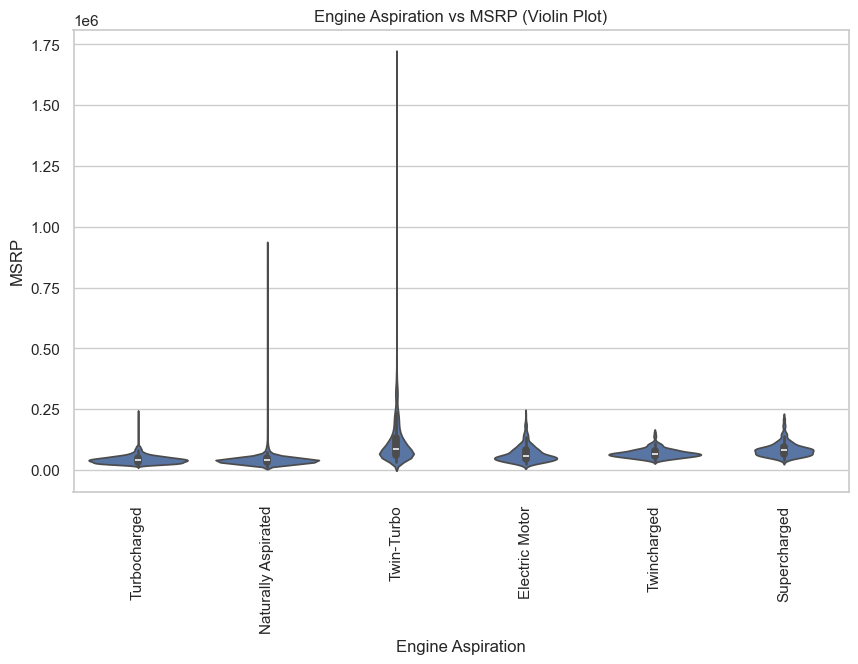

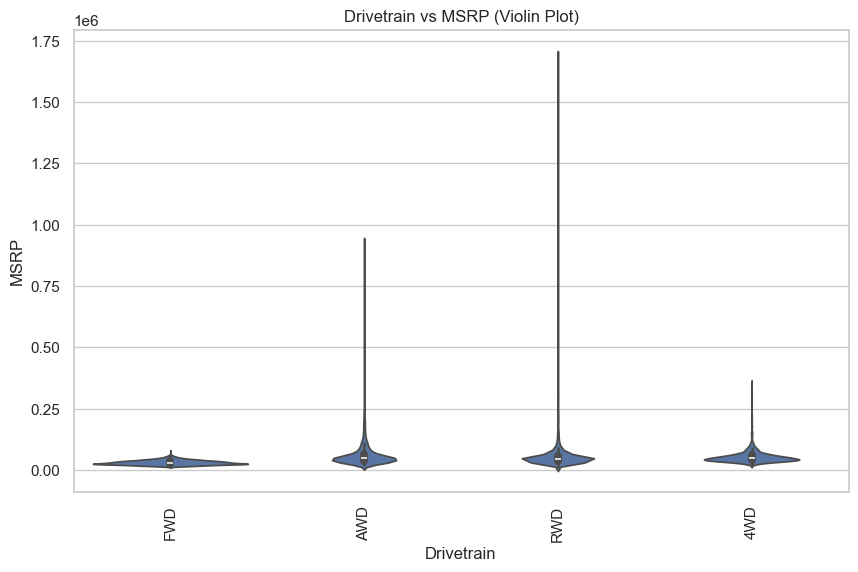

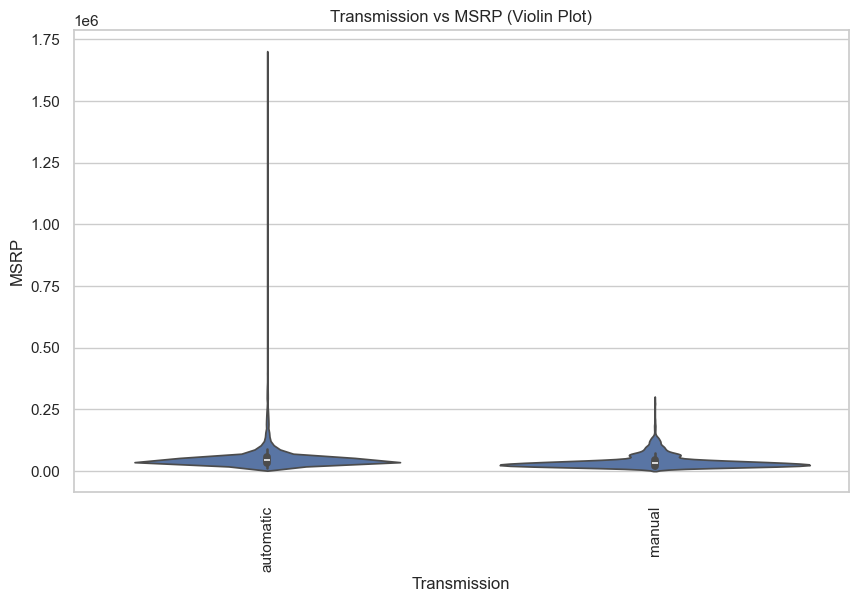

In [33]:
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    
    # Create a violin plot
    sns.violinplot(x=column, y='MSRP', data=cars_data)
    
    plt.xticks(rotation=90)
    plt.title(f'{column} vs MSRP (Violin Plot)')
    plt.xlabel(column)
    plt.ylabel('MSRP')
    plt.show()

Code to Visualize Numerical Columns with Mean

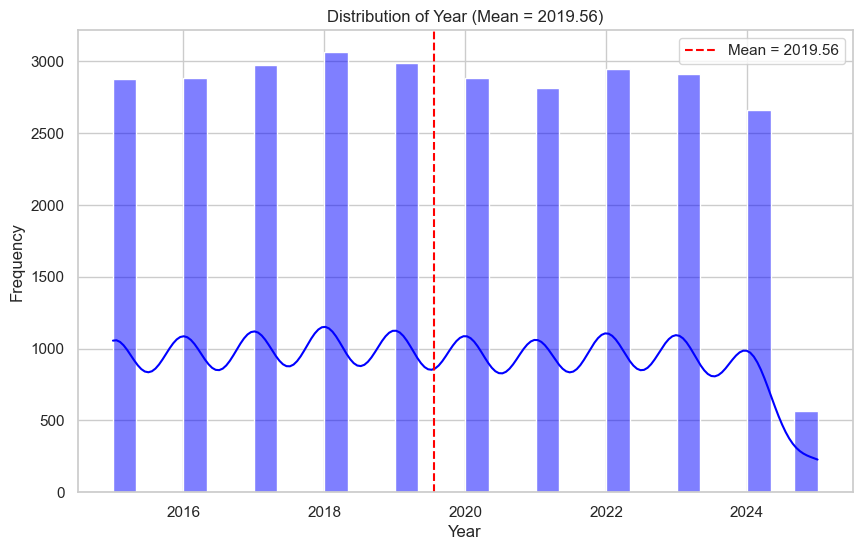

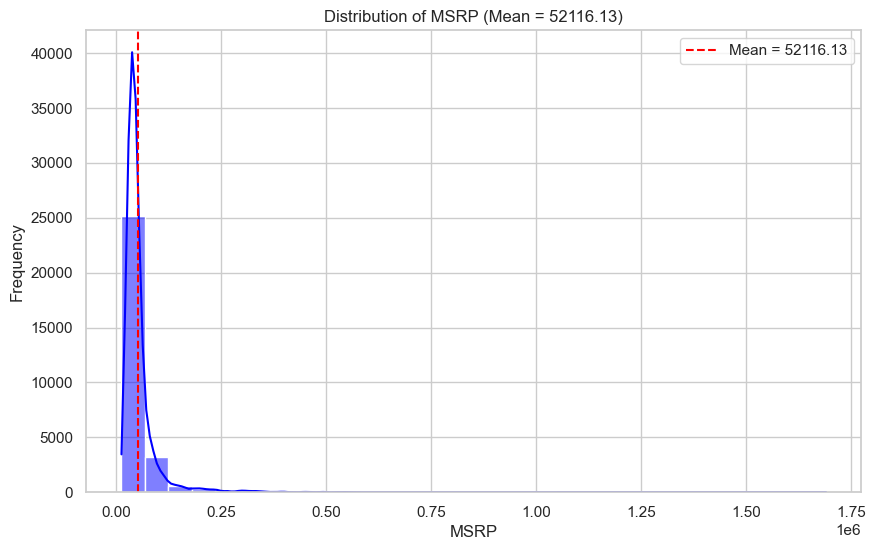

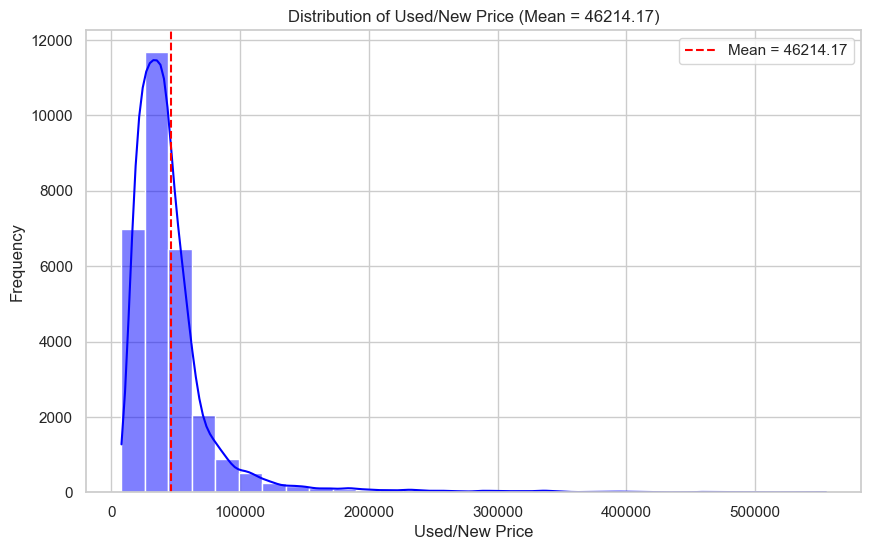

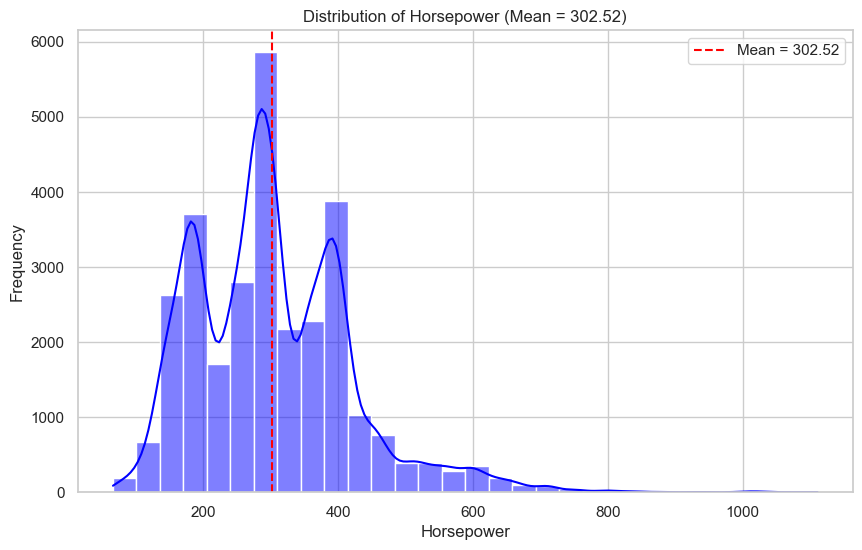

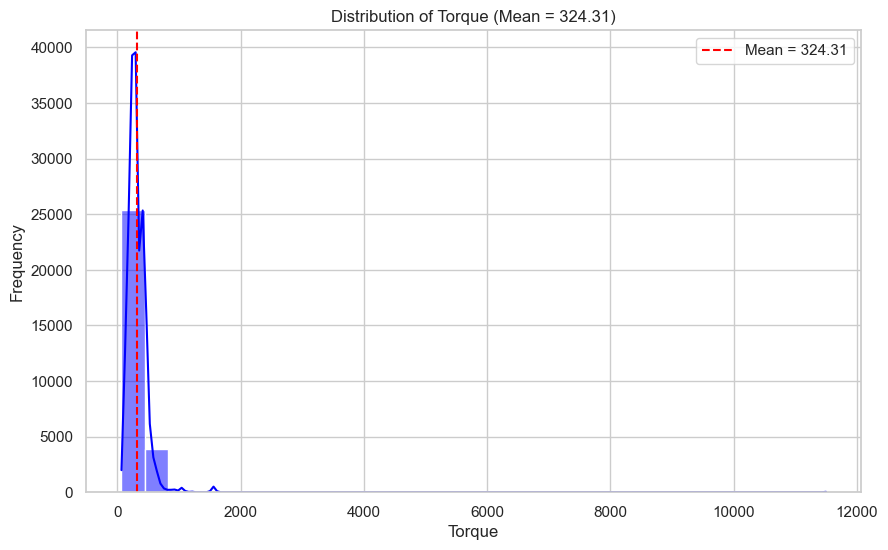

In [34]:
# Set the style for plots
sns.set(style="whitegrid")

# List of numerical columns
numerical_columns = ['Year', 'MSRP', 'Used/New Price', 'Horsepower', 'Torque']

# Loop through each numerical column and create a plot
for column in numerical_columns:
    plt.figure(figsize=(10, 6))  # Set the figure size
    
    # Create a histogram with KDE
    sns.histplot(cars_data[column], kde=True, color='blue', bins=30)
    
    # Add a vertical line for the mean
    mean_value = cars_data[column].mean()
    plt.axvline(mean_value, color='red', linestyle='--', label=f'Mean = {mean_value:.2f}')
    
    # Add title and labels
    plt.title(f'Distribution of {column} (Mean = {mean_value:.2f})')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    
    # Add legend
    plt.legend()
    
    # Show the plot
    plt.show()

Code to Visualize Numerical Columns with Box Plots

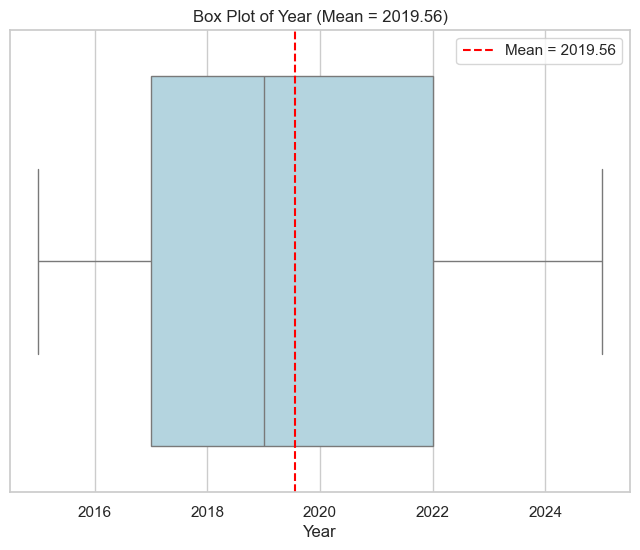

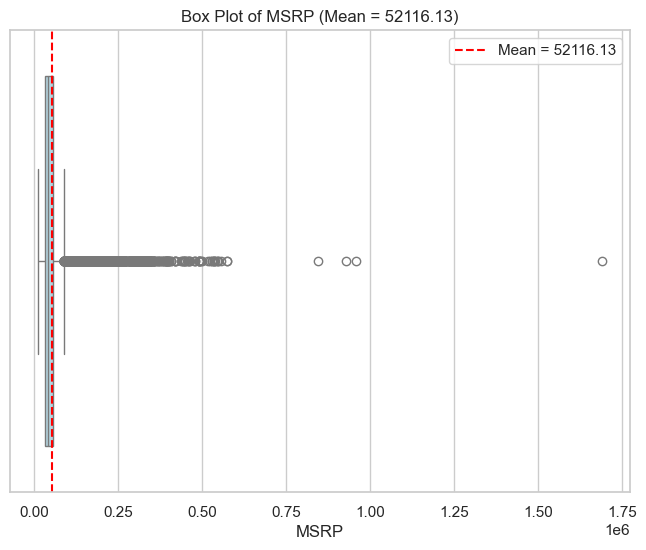

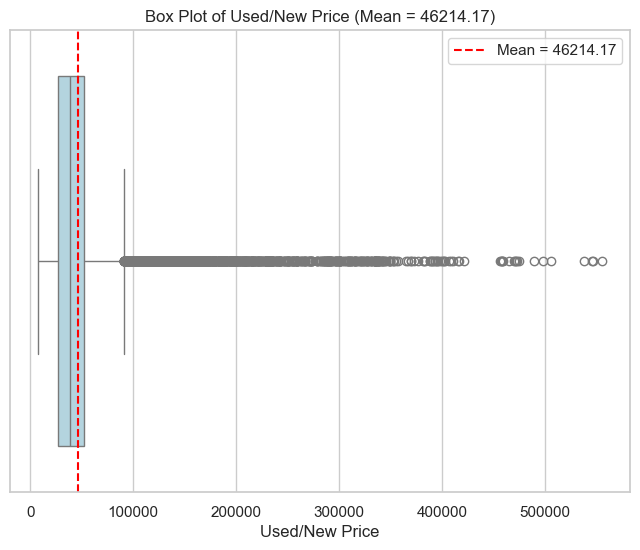

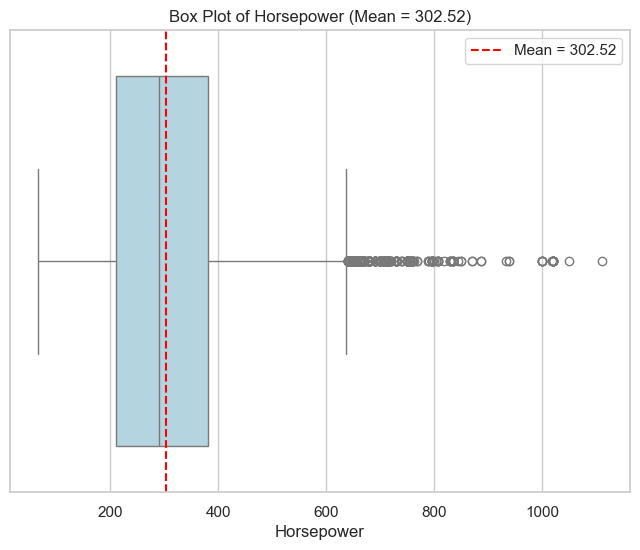

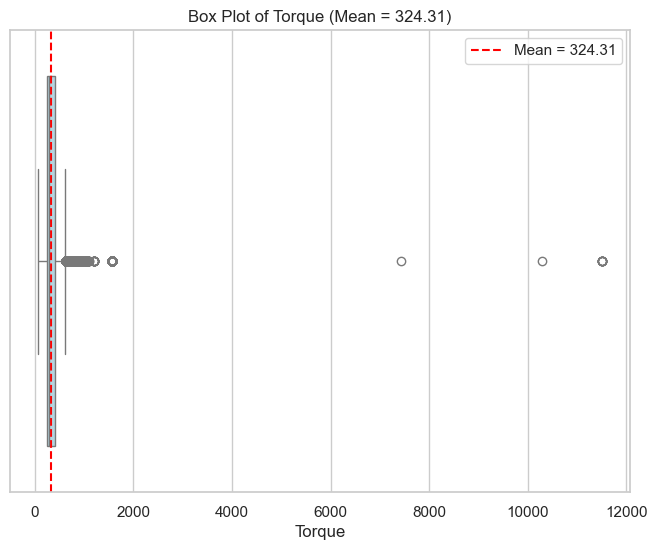

In [35]:
# Loop through each numerical column and create a box plot
for column in numerical_columns:
    plt.figure(figsize=(8, 6))  # Set the figure size
    
    # Create a box plot
    sns.boxplot(x=cars_data[column], color='lightblue')
    
    # Add a vertical line for the mean
    mean_value = cars_data[column].mean()
    plt.axvline(mean_value, color='red', linestyle='--', label=f'Mean = {mean_value:.2f}')
    
    # Add title and labels
    plt.title(f'Box Plot of {column} (Mean = {mean_value:.2f})')
    plt.xlabel(column)
    
    # Add legend
    plt.legend()
    
    # Show the plot
    plt.show()

### FINAL DF

In [36]:
# Drop unnecessary columns
final_cars_data = cars_data.drop(['Model', 'Trim', 'Used/New Price'], axis=1)

# Convert Categorical Variables
# Perform one-hot encoding without dropping the first category
final_cars_data = pd.get_dummies(final_cars_data, columns=['Make', 'Body Size', 'Body Style', 'Engine Aspiration', 'Drivetrain', 'Transmission'], drop_first=False)

# Display the first few rows of the final DataFrame
final_cars_data.head()

,Year,MSRP,Horsepower,Torque,Cylinders_Flat-4,Cylinders_Flat-6,Cylinders_I3,Cylinders_I4,Cylinders_I5,Cylinders_I6,Cylinders_Unknown,Cylinders_V10,Cylinders_V12,Cylinders_V6,Cylinders_V8,Cylinders_W12,Make_Acura,Make_Alfa Romeo,Make_Aston Martin,Make_Audi,Make_BMW,Make_Bentley,Make_Buick,Make_Cadillac,Make_Chevrolet,Make_Chrysler,Make_Dodge,Make_FIAT,Make_Ferrari,Make_Fisker,Make_Ford,Make_GMC,Make_Genesis,Make_Honda,Make_Hyundai,Make_INEOS,Make_INFINITI,Make_Jaguar,Make_Jeep,Make_Karma,Make_Kia,Make_Lamborghini,Make_Land Rover,Make_Lexus,Make_Lincoln,Make_Lotus,Make_Lucid,Make_MINI,Make_Maserati,Make_Mazda,Make_McLaren,Make_Mercedes-Benz,Make_Mitsubishi,Make_Nissan,Make_Polestar,Make_Porsche,Make_Ram,Make_Rivian,Make_Rolls-Royce,Make_Scion,Make_Subaru,Make_Tesla,Make_Toyota,Make_VinFast,Make_Volkswagen,Make_Volvo,Make_smart,Body Size_Compact,Body Size_Large,Body Size_Midsize,Body Style_Cargo Minivan,Body Style_Cargo Van,Body Style_Convertible,Body Style_Convertible SUV,Body Style_Coupe,Body Style_Hatchback,Body Style_Passenger Minivan,Body Style_Passenger Van,Body Style_Pickup Truck,Body Style_SUV,Body Style_Sedan,Body Style_Wagon,Engine Aspiration_Electric Motor,Engine Aspiration_Naturally Aspirated,Engine Aspiration_Supercharged,Engine Aspiration_Turbocharged,Engine Aspiration_Twin-Turbo,Engine Aspiration_Twincharged,Drivetrain_4WD,Drivetrain_AWD,Drivetrain_FWD,Drivetrain_RWD,Transmission_automatic,Transmission_manual
0,2025,32400.0,200.0,192.0,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False
1,2025,34400.0,200.0,192.0,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False
2,2025,37400.0,200.0,192.0,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True
3,2025,37400.0,200.0,192.0,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False
4,2025,50900.0,290.0,267.0,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [37]:
final_cars_data.columns.unique()

Index(['Year', 'MSRP', 'Horsepower', 'Torque', 'Cylinders_Flat-4',
       'Cylinders_Flat-6', 'Cylinders_I3', 'Cylinders_I4', 'Cylinders_I5',
       'Cylinders_I6', 'Cylinders_Unknown', 'Cylinders_V10', 'Cylinders_V12',
       'Cylinders_V6', 'Cylinders_V8', 'Cylinders_W12', 'Make_Acura',
       'Make_Alfa Romeo', 'Make_Aston Martin', 'Make_Audi', 'Make_BMW',
       'Make_Bentley', 'Make_Buick', 'Make_Cadillac', 'Make_Chevrolet',
       'Make_Chrysler', 'Make_Dodge', 'Make_FIAT', 'Make_Ferrari',
       'Make_Fisker', 'Make_Ford', 'Make_GMC', 'Make_Genesis', 'Make_Honda',
       'Make_Hyundai', 'Make_INEOS', 'Make_INFINITI', 'Make_Jaguar',
       'Make_Jeep', 'Make_Karma', 'Make_Kia', 'Make_Lamborghini',
       'Make_Land Rover', 'Make_Lexus', 'Make_Lincoln', 'Make_Lotus',
       'Make_Lucid', 'Make_MINI', 'Make_Maserati', 'Make_Mazda',
       'Make_McLaren', 'Make_Mercedes-Benz', 'Make_Mitsubishi', 'Make_Nissan',
       'Make_Polestar', 'Make_Porsche', 'Make_Ram', 'Make_Rivian',
      

In [38]:
final_cars_data.shape

(29566, 94)

In [39]:
final_cars_data.dtypes

Year                                       int64
MSRP                                     float64
Horsepower                               float64
Torque                                   float64
Cylinders_Flat-4                            bool
Cylinders_Flat-6                            bool
Cylinders_I3                                bool
Cylinders_I4                                bool
Cylinders_I5                                bool
Cylinders_I6                                bool
Cylinders_Unknown                           bool
Cylinders_V10                               bool
Cylinders_V12                               bool
Cylinders_V6                                bool
Cylinders_V8                                bool
Cylinders_W12                               bool
Make_Acura                                  bool
Make_Alfa Romeo                             bool
Make_Aston Martin                           bool
Make_Audi                                   bool
Make_BMW            

### CORRELATION

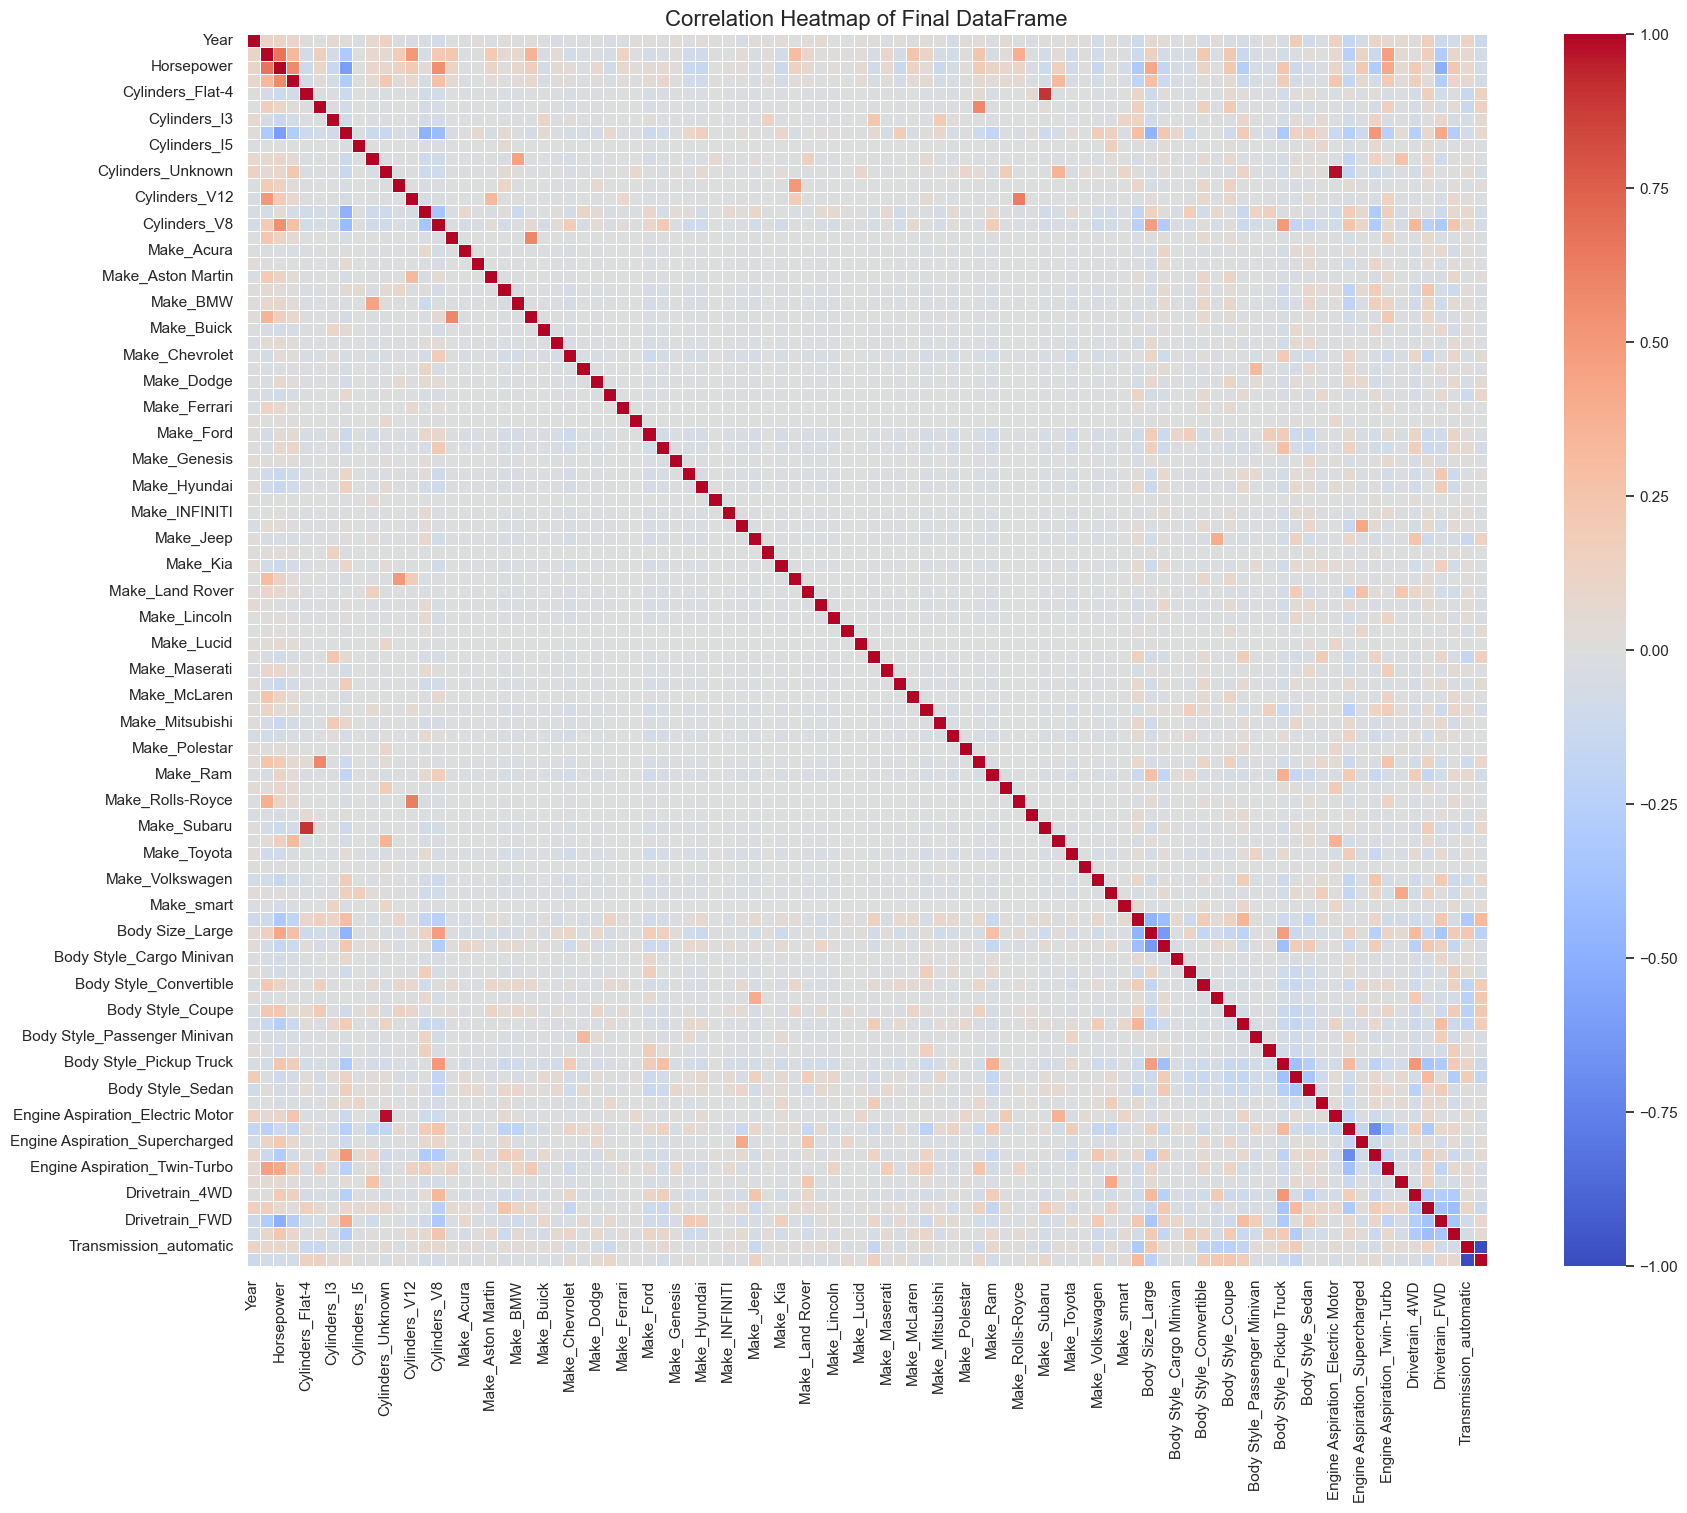

In [40]:
# Calculate the correlation matrix
corr_matrix = final_cars_data.corr()

# Set up the figure size
plt.figure(figsize=(20, 16))

# Create the heatmap
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)

# Add title
plt.title('Correlation Heatmap of Final DataFrame', fontsize=16)

# Show the plot
plt.show()

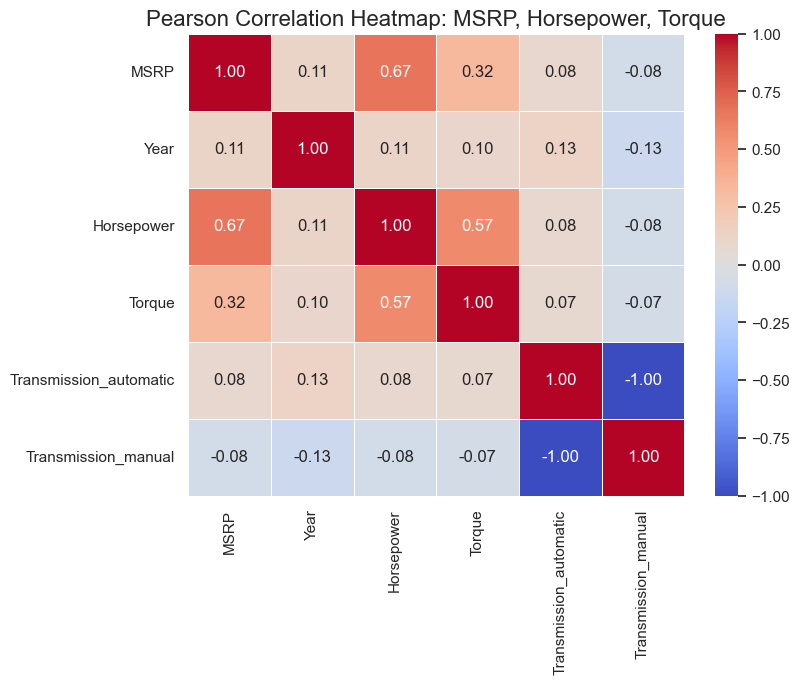

In [41]:

# Select the columns of interest
focus_columns = ['MSRP', 'Year', 'Horsepower', 'Torque', 'Transmission_automatic', 'Transmission_manual']
focus_data = final_cars_data[focus_columns]

# Calculate the correlation matrix using Pearson method
corr_matrix = focus_data.corr(method='pearson')

# Set up the figure size
plt.figure(figsize=(8, 6))

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, fmt='.2f')

# Add title
plt.title('Pearson Correlation Heatmap: MSRP, Horsepower, Torque', fontsize=16)

# Show the plot
plt.show()

### ML STEPS 

1-Feature Importance  

2- Train test split  ( Feature Importance: Use techniques like Random Forest & decision tree)

3-. Model Building (Linear Regression: For a baseline model. Random Forest: For handling non-linear relationships.)

4- Hyperparameter Tuning (Optimize your model’s hyperparameters using techniques like Grid Search or Random Search.)

5- Model Evaluation (Mean Squared Error (MSE) , R-squared (R2), Mean Absolute Error (MAE))

6-  Cross-Validation (Use cross-validation to ensure your model’s performance is consistent across different subsets of the data)

7- Save the Model

8 - . Deploy the Model (Deploy your model as a web application or API using frameworks like Flask, FastAPI, or Streamlit.)

The code uses a decision tree to identify important features and a linear regression model to predict the target variable.

Combining these techniques provides insights into feature importance and a baseline model for regression.

### Calculating feature importance with DECISION TREE 

In [42]:
# SPLIT THE DATA 

X = final_cars_data.drop(['MSRP'], axis=1).values
X_columns = final_cars_data.drop(['MSRP'], axis=1)
y = final_cars_data['MSRP'].astype('int')

print(y.shape)

(29566,)


In [43]:
# DecisionTree estimaters RUN 

from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=10)

dt.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)

In [45]:
for i, column in enumerate(final_cars_data.drop('MSRP', axis=1)):
    print('Importance of feature {}:, {:.3f}'.format(column, dt.feature_importances_[i]))

    fi = pd.DataFrame({'Variable' : [column], 'Feature Importance Score': [dt.feature_importances_[i]]})

    try:
        final_fi = pd.concat([final_fi, fi], ignore_index = True)
    except:
        final_fi = fi


#ordering the data

final_fi = final_fi.sort_values(by = 'Feature Importance Score', ascending = False).reset_index()
final_fi

Importance of feature Year:, 0.159
Importance of feature Horsepower:, 0.230
Importance of feature Torque:, 0.293
Importance of feature Cylinders_Flat-4:, 0.000
Importance of feature Cylinders_Flat-6:, 0.000
Importance of feature Cylinders_I3:, 0.001
Importance of feature Cylinders_I4:, 0.001
Importance of feature Cylinders_I5:, 0.000
Importance of feature Cylinders_I6:, 0.001
Importance of feature Cylinders_Unknown:, 0.000
Importance of feature Cylinders_V10:, 0.000
Importance of feature Cylinders_V12:, 0.000
Importance of feature Cylinders_V6:, 0.005
Importance of feature Cylinders_V8:, 0.003
Importance of feature Cylinders_W12:, 0.000
Importance of feature Make_Acura:, 0.000
Importance of feature Make_Alfa Romeo:, 0.000
Importance of feature Make_Aston Martin:, 0.000
Importance of feature Make_Audi:, 0.003
Importance of feature Make_BMW:, 0.002
Importance of feature Make_Bentley:, 0.000
Importance of feature Make_Buick:, 0.000
Importance of feature Make_Cadillac:, 0.002
Importance of

,index,Variable,Feature Importance Score
0,2,Torque,0.292661
1,1,Horsepower,0.229968
2,0,Year,0.158839
3,82,Engine Aspiration_Naturally Aspirated,0.035631
4,88,Drivetrain_AWD,0.033844
5,77,Body Style_Pickup Truck,0.031218
6,78,Body Style_SUV,0.020620
7,68,Body Size_Midsize,0.018705
8,90,Drivetrain_RWD,0.014765
9,87,Drivetrain_4WD,0.013979


C:\Users\tevfi\AppData\Local\Temp\ipykernel_22168\3553419718.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature Importance Score', y='Variable', data=top_features, palette='viridis')


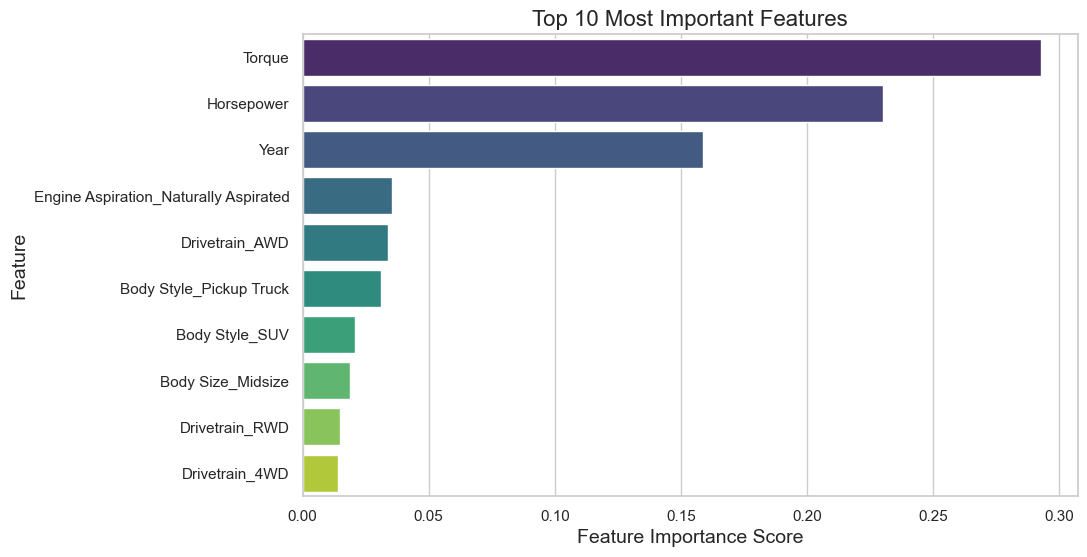

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `final_fi` is your DataFrame with feature importance scores
# Example structure of `final_fi`:
# final_fi = pd.DataFrame({
#     'Variable': ['Torque', 'Horsepower', 'Year', ...],
#     'Feature Importance Score': [0.45, 0.30, 0.25, ...]
# })

# Sort the DataFrame by feature importance score (descending order)
final_fi_sorted = final_fi.sort_values(by='Feature Importance Score', ascending=False)

# Select the top N features (e.g., top 5 or top 10)
top_n = 10  # Change this to 5 if you only want the top 5 features
top_features = final_fi_sorted.head(top_n)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature Importance Score', y='Variable', data=top_features, palette='viridis')

# Add labels and title
plt.title(f'Top {top_n} Most Important Features', fontsize=16)
plt.xlabel('Feature Importance Score', fontsize=14)
plt.ylabel('Feature', fontsize=14)

# Display the plot
plt.show()

### SPLITTING THE DATA

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.2, random_state=42)

In [48]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(23652, 93)
(5914, 93)
(23652,)
(5914,)


### LINEAR REGRESSION MODEL

In [49]:
# Training the regression 
from sklearn.linear_model import LinearRegression
lm = LinearRegression(fit_intercept=True)
lm.fit(X_train, y_train)


LinearRegression()

In [50]:
y_pred = lm.predict(X_train)

In [51]:
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from math import sqrt

# model accuracy on training data

print(lm.score(X_train, y_train))
print("R2 score on Training Data: " ,r2_score(y_train, y_pred))


0.8461715012727491
R2 score on Training Data:  0.8461715012727491


In [52]:
#model accuracy on testing data

print(lm.score(X_test, y_test))

0.8354792905112163


In [53]:
# Root mean squared error 

print('Training Data: ' ,sqrt(mean_squared_error(y_train, y_pred)))
print('Testing Data: ' ,sqrt(mean_squared_error(y_test, lm.predict(X_test))))
      
           


Training Data:  16892.8502860648
Testing Data:  16999.15251797239


In [54]:
#Mean absolute Error(MAE)

print('Training Data: ' ,mean_absolute_error(y_train, y_pred))
print('Testing Data: ', mean_absolute_error(y_test, lm.predict(X_test)))

Training Data:  7932.833784392497
Testing Data:  8112.480755671685


### CROSS VALIDATION 

In [55]:
from sklearn.model_selection import cross_val_score

# Initialize the model
lm = LinearRegression(fit_intercept=True)

# Perform 5-fold cross-validation for R² score
cv_scores = cross_val_score(lm, X, y, cv=5, scoring='r2')

# Print the cross-validation scores
print("Cross-Validation R² Scores:", cv_scores)
print("Mean R² Score:", cv_scores.mean())
print("Standard Deviation of R² Scores:", cv_scores.std())

Cross-Validation R² Scores: [0.86789945 0.75973597 0.86666121 0.87840578 0.81226808]
Mean R² Score: 0.8369941002410289
Standard Deviation of R² Scores: 0.04501200015104465


### RANDOM FOREST 

In [56]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
import numpy as np

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
# Initialize the model
rf_regressor = RandomForestRegressor(random_state=42, n_estimators=100)

# Train the model
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [59]:
# Predict on training and testing data
y_train_pred = rf_regressor.predict(X_train)
y_test_pred = rf_regressor.predict(X_test)

In [60]:
# Training data evaluation
print("Training R² Score:", r2_score(y_train, y_train_pred))
print("Training RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))

# Testing data evaluation
print("Testing R² Score:", r2_score(y_test, y_test_pred))
print("Testing RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))

Training R² Score: 0.9796536556961191
Training RMSE: 6143.667835421194
Testing R² Score: 0.952088839130206
Testing RMSE: 9173.505601231158


In [61]:
mae = mean_absolute_error(y_test, y_test_pred)
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 4609.1518752517295


In [62]:
# Perform 5-fold cross-validation for R² score
cv_scores = cross_val_score(rf_regressor, X, y, cv=5, scoring='r2')

print("Cross-Validation R² Scores:", cv_scores)
print("Mean R² Score:", cv_scores.mean())
print("Standard Deviation of R² Scores:", cv_scores.std())

Cross-Validation R² Scores: [0.87053149 0.83779155 0.97312982 0.96909678 0.8534925 ]
Mean R² Score: 0.9008084272086301
Standard Deviation of R² Scores: 0.05834432249700546


In [63]:
import numpy as np
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Check for outliers or imbalance in the target variable
    print(f"Fold {fold + 1}:")
    print("Target distribution in test fold:", np.unique(y_test, return_counts=True))

Fold 1:
Target distribution in test fold: (array([ 12270,  13220,  13795, ..., 538000, 555000, 929000]), array([1, 1, 1, ..., 1, 1, 1], dtype=int64))
Fold 2:
Target distribution in test fold: (array([  11990,   13600,   13990, ...,  573966,  845000, 1690000]), array([1, 1, 1, ..., 2, 1, 1], dtype=int64))
Fold 3:
Target distribution in test fold: (array([ 11990,  12110,  12660, ..., 394500, 450000, 490700]), array([1, 1, 1, ..., 1, 1, 1], dtype=int64))
Fold 4:
Target distribution in test fold: (array([ 12460,  12995,  13000, ..., 535500, 548800, 958966]), array([1, 2, 1, ..., 1, 1, 1], dtype=int64))
Fold 5:
Target distribution in test fold: (array([ 11990,  12310,  13050, ..., 522948, 530000, 546847]), array([1, 1, 1, ..., 1, 2, 1], dtype=int64))


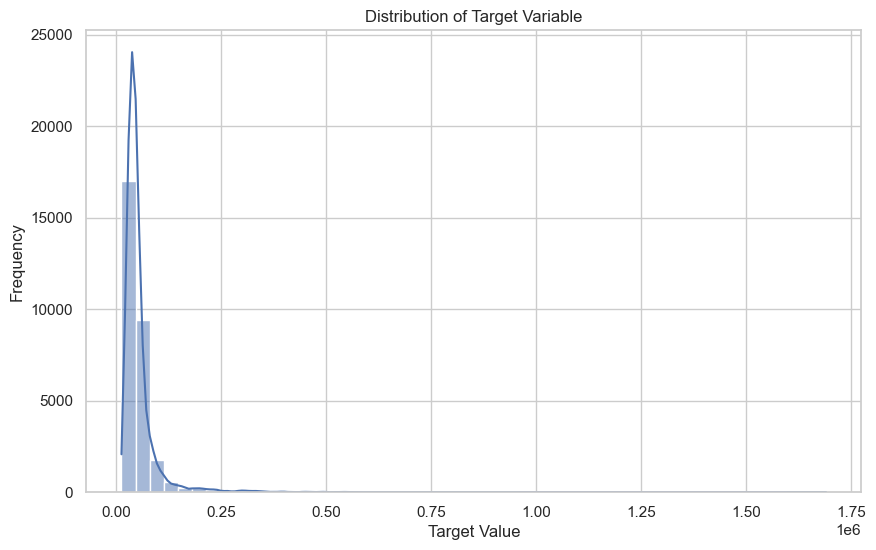

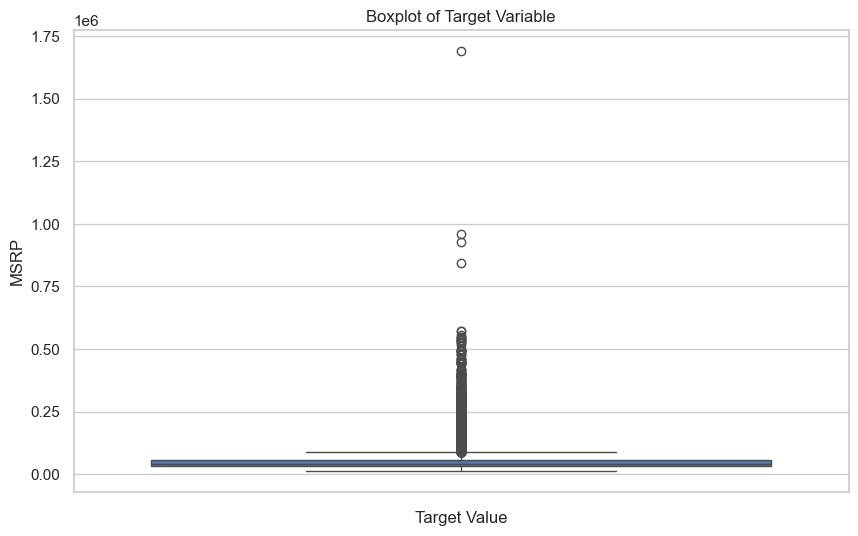

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=50, kde=True)
plt.title("Distribution of Target Variable")
plt.xlabel("Target Value")
plt.ylabel("Frequency")
plt.show()

# Plot boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(y)
plt.title("Boxplot of Target Variable")
plt.xlabel("Target Value")
plt.show()

There are outlier but it's ok to have them because it's normal for our datase. we want them 

### SAVING THE MODEL 

In [65]:
#import pickle

# Save the model to a file
#with open('random_forest_model.pkl', 'wb') as file:
    #pickle.dump(rf_regressor, file)

In [66]:
for column in final_cars_data:
    unique_vals = np.unique(final_cars_data[column].fillna('0'))
    nr_values = len(unique_vals)
    if nr_values <= 12:
        print("The number of values for feature {} :{} -- {}".format(column, nr_values, unique_vals))
    else:
        print("The number of values for feature {} :{}".format(column, nr_values))

The number of values for feature Year :11 -- [2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025]
The number of values for feature MSRP :9495
The number of values for feature Horsepower :443
The number of values for feature Torque :375
The number of values for feature Cylinders_Flat-4 :2 -- [False  True]
The number of values for feature Cylinders_Flat-6 :2 -- [False  True]
The number of values for feature Cylinders_I3 :2 -- [False  True]
The number of values for feature Cylinders_I4 :2 -- [False  True]
The number of values for feature Cylinders_I5 :2 -- [False  True]
The number of values for feature Cylinders_I6 :2 -- [False  True]
The number of values for feature Cylinders_Unknown :2 -- [False  True]
The number of values for feature Cylinders_V10 :2 -- [False  True]
The number of values for feature Cylinders_V12 :2 -- [False  True]
The number of values for feature Cylinders_V6 :2 -- [False  True]
The number of values for feature Cylinders_V8 :2 -- [False  True]
The number of value

In [67]:
# Training the regression 
from sklearn.linear_model import LinearRegression
lm_2 = LinearRegression(fit_intercept=True)
lm_2.fit(X_train, y_train)

y_pred = lm_2.predict(X_train)

from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from math import sqrt

# model accuracy on training data

print(lm_2.score(X_train, y_train))
print("R2 score on Training Data: " ,r2_score(y_train, y_pred))


0.8294166259251696
R2 score on Training Data:  0.8294166259251696


In [68]:
import pickle

# Save the model to a file
#with open('linear_regression_model.pkl', 'wb') as file:
    #pickle.dump(lm_2, file)

### XG BOOST MODEL 

In [69]:
#!pip install xgboost

In [80]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# Modeli oluştur ve eğit
xgb = XGBRegressor(n_estimators=100, learning_rate=0.6)
xgb.fit(X_train, y_train)

# Tahmin yap
y_pred = xgb.predict(X_test)

# Hata oranını ölç
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")


Mean Absolute Percentage Error: 8.45%


In [81]:
import xgboost as xgb

# Modeli pickle ile kaydet
#with open("xgb_model.pkl", "wb") as f:
    #pickle.dump(xgb_model, f)
#print("XGBoost modeli pickle ile kaydedildi.")

In [82]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # RMSE = sqrt(MSE)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 4476.2408883894595
Mean Squared Error (MSE): 61056686.279345535
Root Mean Squared Error (RMSE): 7813.877800384745
R-squared (R²): 0.9687664528722209


[6928.92955209 5491.83384277 4630.26824589 4185.83920558 5438.56849068]
Mean CV MAE: 5335.087867402215


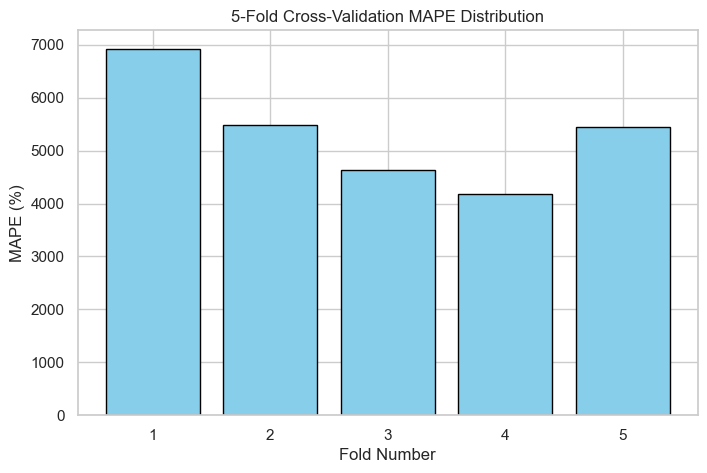

In [73]:
from sklearn.model_selection import cross_val_score

# XGBoost modelini oluştur
xgb = XGBRegressor(n_estimators=100, learning_rate=0.6)

# Cross validation ile MAE ölçümü
cv_mae = cross_val_score(xgb, X_train, y_train, cv=5, 
                         scoring='neg_mean_absolute_error')

# Sonuçları pozitif hale getir
cv_mae = -cv_mae

print(cv_mae)
print(f"Mean CV MAE: {cv_mae.mean()}")

# Fold sonuçlarını görselleştir
plt.figure(figsize=(8,5))
plt.bar(range(1, 6), cv_mae, color="skyblue", edgecolor="black")
plt.xticks(range(1, 6))
plt.xlabel("Fold Number")
plt.ylabel("MAPE (%)")
plt.title("5-Fold Cross-Validation MAPE Distribution")
plt.show()



### BEST LEARNING RATE

In [74]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

param_grid = {'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 0.6, 0.8, 1.0]}
xgb = XGBRegressor(n_estimators=100)

grid_search = GridSearchCV(xgb, param_grid, cv=5, 
                           scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best Learning Rate: {grid_search.best_params_['learning_rate']}")
print(f"Best Score: {-grid_search.best_score_}") 


Best Learning Rate: 0.6
Best Score: 0.09847571033295999


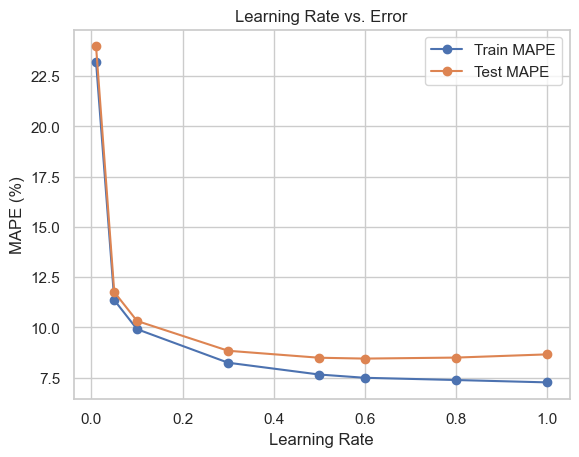

In [75]:
import matplotlib.pyplot as plt

learning_rates = [0.01, 0.05, 0.1, 0.3, 0.5, 0.6, 0.8, 1.0]
train_errors = []
test_errors = []

for lr in learning_rates:
    xgb = XGBRegressor(n_estimators=100, learning_rate=lr)
    xgb.fit(X_train, y_train)
    
    train_pred = xgb.predict(X_train)
    test_pred = xgb.predict(X_test)
    
    train_mape = np.mean(np.abs((y_train - train_pred) / y_train)) * 100
    test_mape = np.mean(np.abs((y_test - test_pred) / y_test)) * 100
    
    train_errors.append(train_mape)
    test_errors.append(test_mape)

plt.plot(learning_rates, train_errors, label="Train MAPE", marker="o")
plt.plot(learning_rates, test_errors, label="Test MAPE", marker="o")
plt.xlabel("Learning Rate")
plt.ylabel("MAPE (%)")
plt.legend()
plt.title("Learning Rate vs. Error")
plt.show()


### 5 FOLD CROSS VALIDATION

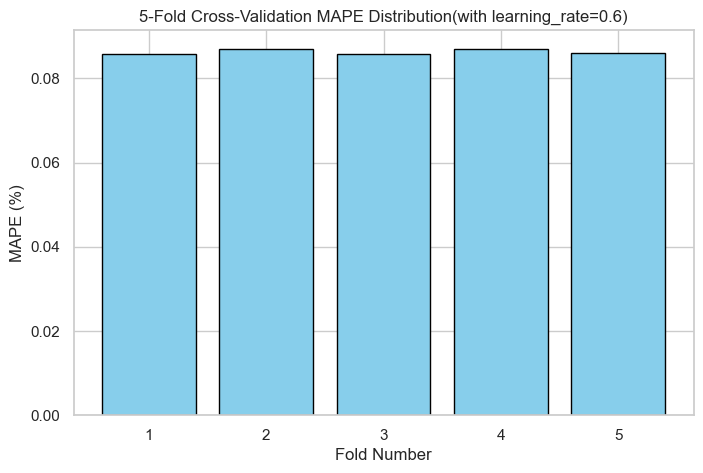

Mean MAPE: 0.0863
MAPE Std Dev: 0.0006


In [76]:
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt

# 5-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
xgb_best = XGBRegressor(n_estimators=100, learning_rate=0.6)

# Her fold için MAPE değerlerini hesapla
scores = cross_val_score(xgb_best, X_train, y_train, scoring="neg_mean_absolute_percentage_error", cv=kf)
mape_scores = -scores  # Negatif değer olduğu için işaret değiştiriyoruz

# Fold sonuçlarını görselleştir
plt.figure(figsize=(8,5))
plt.bar(range(1, 6), mape_scores, color="skyblue", edgecolor="black")
plt.xticks(range(1, 6))
plt.xlabel("Fold Number")
plt.ylabel("MAPE (%)")
plt.title("5-Fold Cross-Validation MAPE Distribution(with learning_rate=0.6)")
plt.show()

# Ortalama ve standart sapma
mean_mape = np.mean(mape_scores)
std_mape = np.std(mape_scores)
print(f"Mean MAPE: {mean_mape:.4f}")
print(f"MAPE Std Dev: {std_mape:.4f}")


C:\Users\tevfi\AppData\Local\Temp\ipykernel_22168\3429228765.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=mae_values, palette='viridis')


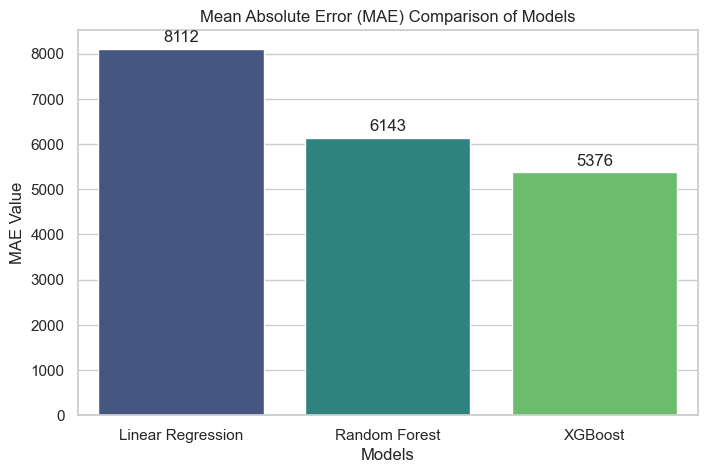

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# Modeller ve MAE değerleri (örnek olarak senin değerlerini ekledim)
models = ['Linear Regression', 'Random Forest', 'XGBoost']
mae_values = [8112, 6143, 5376]  # Kendi sonuçlarına göre güncelle

# Grafiği çiz
plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=mae_values, palette='viridis')

# Başlık ve etiketler
plt.title('Mean Absolute Error (MAE) Comparison of Models')
plt.ylabel('MAE Value')
plt.xlabel('Models')

# Değerleri üzerine yazdır
for i, v in enumerate(mae_values):
    plt.text(i, v + 150, str(round(v, 2)), ha='center', fontsize=12)

# Grafiği göster
plt.show()


In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px

# Example: Interactive scatter plot for Horsepower vs. MSRP
fig = px.scatter(final_cars_data, x='Horsepower', y='MSRP', color='Year', hover_data=['Torque', 'Engine Aspiration'],
                 title='Horsepower vs. MSRP (Colored by Year)')

# Display the interactive plot
fig.show()

ValueError: Value of 'hover_data_1' is not the name of a column in 'data_frame'. Expected one of ['Year', 'MSRP', 'Horsepower', 'Torque', 'Cylinders_Flat-4', 'Cylinders_Flat-6', 'Cylinders_I3', 'Cylinders_I4', 'Cylinders_I5', 'Cylinders_I6', 'Cylinders_Unknown', 'Cylinders_V10', 'Cylinders_V12', 'Cylinders_V6', 'Cylinders_V8', 'Cylinders_W12', 'Make_Acura', 'Make_Alfa Romeo', 'Make_Aston Martin', 'Make_Audi', 'Make_BMW', 'Make_Bentley', 'Make_Buick', 'Make_Cadillac', 'Make_Chevrolet', 'Make_Chrysler', 'Make_Dodge', 'Make_FIAT', 'Make_Ferrari', 'Make_Fisker', 'Make_Ford', 'Make_GMC', 'Make_Genesis', 'Make_Honda', 'Make_Hyundai', 'Make_INEOS', 'Make_INFINITI', 'Make_Jaguar', 'Make_Jeep', 'Make_Karma', 'Make_Kia', 'Make_Lamborghini', 'Make_Land Rover', 'Make_Lexus', 'Make_Lincoln', 'Make_Lotus', 'Make_Lucid', 'Make_MINI', 'Make_Maserati', 'Make_Mazda', 'Make_McLaren', 'Make_Mercedes-Benz', 'Make_Mitsubishi', 'Make_Nissan', 'Make_Polestar', 'Make_Porsche', 'Make_Ram', 'Make_Rivian', 'Make_Rolls-Royce', 'Make_Scion', 'Make_Subaru', 'Make_Tesla', 'Make_Toyota', 'Make_VinFast', 'Make_Volkswagen', 'Make_Volvo', 'Make_smart', 'Body Size_Compact', 'Body Size_Large', 'Body Size_Midsize', 'Body Style_Cargo Minivan', 'Body Style_Cargo Van', 'Body Style_Convertible', 'Body Style_Convertible SUV', 'Body Style_Coupe', 'Body Style_Hatchback', 'Body Style_Passenger Minivan', 'Body Style_Passenger Van', 'Body Style_Pickup Truck', 'Body Style_SUV', 'Body Style_Sedan', 'Body Style_Wagon', 'Engine Aspiration_Electric Motor', 'Engine Aspiration_Naturally Aspirated', 'Engine Aspiration_Supercharged', 'Engine Aspiration_Turbocharged', 'Engine Aspiration_Twin-Turbo', 'Engine Aspiration_Twincharged', 'Drivetrain_4WD', 'Drivetrain_AWD', 'Drivetrain_FWD', 'Drivetrain_RWD', 'Transmission_automatic', 'Transmission_manual'] but received: Engine Aspiration

### CatBoost Modeli ile Tahmin

In [78]:
#!pip install catboost


In [79]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

# CatBoost modelini oluştur
cat_model = CatBoostRegressor(iterations=1000, 
                              learning_rate=0.6, 
                              depth=6, 
                              loss_function='MAE', 
                              verbose=100)

# Modeli eğit
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

# Tahmin yap
y_pred = cat_model.predict(X_test)

# Hata oranını ölç (Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)
print(f"CatBoost MAE: {mae}")

# 5-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(cat_model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')

# Sonuçları pozitif hale getir
cv_scores = -cv_scores
print(f"Cross-Validation MAE Scores: {cv_scores}")
print(f"Mean CV MAE: {np.mean(cv_scores)}")


0:	learn: 14278.1298158	test: 15446.5504960	best: 15446.5504960 (0)	total: 165ms	remaining: 2m 44s
100:	learn: 4527.4817596	test: 5077.9621647	best: 5077.9621647 (100)	total: 726ms	remaining: 6.46s
200:	learn: 3956.6891744	test: 4720.1737670	best: 4716.7506724 (188)	total: 1.29s	remaining: 5.12s
300:	learn: 3719.4398579	test: 4599.9470380	best: 4599.9470380 (300)	total: 1.91s	remaining: 4.43s
400:	learn: 3611.5117846	test: 4544.0195650	best: 4544.0195650 (400)	total: 2.48s	remaining: 3.7s
500:	learn: 3525.3234524	test: 4527.5836259	best: 4522.1592706 (484)	total: 2.98s	remaining: 2.96s
600:	learn: 3471.9529271	test: 4521.4964192	best: 4520.4339156 (553)	total: 3.5s	remaining: 2.33s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 4520.433916
bestIteration = 553

Shrink model to first 554 iterations.
CatBoost MAE: 4520.433916560667
0:	learn: 14635.8350251	total: 4.97ms	remaining: 4.96s
100:	learn: 4532.1761313	total: 483ms	remaining: 4.3s
200:	learn: 4022.2746587	total: